In [23]:
using OrdinaryDiffEq

function f(u, p, t)
    return [p[1] * u[1] - p[2] * u[1] * u[2], -p[3] * u[2] + p[4] * u[1] * u[2]]
end

p = [1.5, 1.0, 3.0, 1.0]
u0 = [1.0, 1.0]
prob_oop = ODEProblem{false}(f, u0, (0.0, 3.0), p)
true_sol = solve(prob_oop, Tsit5(), saveat=0.01)

retcode: Success
Interpolation: 1st order linear
t: 301-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 ⋮
 2.92
 2.93
 2.94
 2.95
 2.96
 2.97
 2.98
 2.99
 3.0
u: 301-element Vector{Vector{Float64}}:
 [1.0, 1.0]
 [1.0051122697054304, 0.9802235489841001]
 [1.0104482482084793, 0.960888402913325]
 [1.0160067852516195, 0.9419859539931973]
 [1.0217868581271057, 0.9235077034160883]
 [1.0277875716769742, 0.9054452613612183]
 [1.034008158293044, 0.8877903469946546]
 [1.0404479779169147, 0.8705347884693151]
 [1.0471065141055134, 0.8536705240234226]
 [1.0539833005834183, 0.8371896275033469]
 ⋮
 [1.0163110485798996, 2.24060823429365]
 [1.0090249094070312, 2.1965201574788167]
 [1.0022263010549455, 2.15315467122958]
 [0.9958993615105561, 2.110513230272754]
 [0.9900294369696907, 2.0685953916533597]
 [0.9846030818370904, 2.02739881473463]
 [0.9796080587264039, 1.986919261197954]
 [0.9750333384601948, 1.9471505950429426]
 [0.970869100069937, 1.908084782587384]

In [24]:
using ModelingToolkit
using Sophon, IntervalSets
using Optimization, OptimizationOptimJL

@parameters t
@variables x(..), y(..)

Dₜ = Differential(t)

eqs = [Dₜ(x(t)) ~ p[1] * x(t) - p[2] * x(t) * y(t),
      Dₜ(y(t)) ~ -p[3] * y(t) + p[4] * x(t) * y(t)]

domain = [t ∈ 0 .. 3.0]

bcs = [x(0.0) ~ 1.0, y(0.0) ~ 1.0]

@named lotka_volterra = PDESystem(eqs, bcs, domain, [t], [x(t), y(t)])

PDESystem
Equations: Equation[Differential(t)(x(t)) ~ 1.5x(t) - x(t)*y(t), Differential(t)(y(t)) ~ x(t)*y(t) - 3.0y(t)]
Boundary Conditions: Equation[x(0.0) ~ 1.0, y(0.0) ~ 1.0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0..3.0)]
Dependent Variables: Num[x(t), y(t)]
Independent Variables: Num[t]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [25]:
pinn = PINN(x = FullyConnected(1, 1, sin; hidden_dims=6, num_layers=2),
            y = FullyConnected(1, 1, sin; hidden_dims=6, num_layers=2))

sampler = BetaRandomSampler(200, 1)
strategy = NonAdaptiveTraining(1,50)

prob = Sophon.discretize(lotka_volterra, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(x = (layer_1 = (weight = [-0.5615369081497192; -0.16114884614944458; … ; 1.416480541229248; 1.6200652122497559;;], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [0.1137622520327568 0.7201630473136902 … -0.3457481563091278 0.190358504652977; 0.017038343474268913 -0.005773424636572599 … 0.8952435851097107 -0.827506959438324; … ; -0.3549773395061493 0.8084535002708435 … -0.2183159440755844 0.603563129901886; 0.6854413151741028 0.1136779710650444 … -0.40072473883628845 -0.548225462436676], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [0.22353647649288177 0.09668635576963425 … 0.5594643950462341 0.18696092069149017], bias = [0.0;;])), y = (layer_1 = (weight = [-1.7814186811447144; 1.8093156814575195; … ; 1.551371455192566; -2.2838311195373535;;], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [0.7662778496742249 -0.4115771949291229 … -0.5397418141365051 -0.3526857793331146; 0.6222966313362122 0.94

In [26]:
function callback(p, l)
    println("Loss: $l")
    return false
end

@time res = Optimization.solve(prob, BFGS(); maxiters=2000, callback=callback)

Loss: 106.03587152256682
Loss: 5.534807797321552
Loss: 4.839223520427247
Loss: 4.1711552081927366
Loss: 2.667407621683965
Loss: 2.271337589406748
Loss: 1.8093728707159062
Loss: 1.2795479534863685
Loss: 1.1371423293879395
Loss: 1.1074727685289865
Loss: 1.0592755143146055
Loss: 0.9949137139500446
Loss: 0.9768465876758236
Loss: 0.9634573238232765


Loss: 0.9280534154915834
Loss: 0.9080473260141858
Loss: 0.8947833841835466
Loss: 0.88855593379514
Loss: 0.8672333913997851
Loss: 0.8578294724797012
Loss: 0.8433547966537235
Loss: 0.8329104407619026
Loss: 0.8176921506839897
Loss: 0.8034398444496109
Loss: 0.7871728557967432


Loss: 0.7825374486492597
Loss: 0.7756420209167296
Loss: 0.7697631213567373
Loss: 0.7618527664537256
Loss: 0.7579032892752486
Loss: 0.7506109235825797
Loss: 0.7475783106902921
Loss: 0.7440313136696691
Loss: 0.7428149652196532
Loss: 0.7412812264231848
Loss: 0.7369525581973595
Loss: 0.7344956520148564
Loss: 0.7295739769177575
Loss: 0.7241965798017863
Loss: 0.7171158520174377


Loss: 0.7126926897482626
Loss: 0.7079486415722975
Loss: 0.7025969961130148
Loss: 0.6993583064164891
Loss: 0.6902035179455931
Loss: 0.6839855996057685
Loss: 0.6633103041518708


Loss: 0.6559388224173716
Loss: 0.6383874793136208
Loss: 0.62061130140738
Loss: 0.6107348706727794
Loss: 0.5956530450228782
Loss: 0.581200765182283
Loss: 0.5625410052916558


Loss: 0.5275636966889894
Loss: 0.5203224575852646
Loss: 0.496602694875872
Loss: 0.48276775732583377
Loss: 0.462480483639271
Loss: 0.4352795535212602
Loss: 0.4189716096208492
Loss: 0.3853005745789389
Loss: 0.35557132992656204
Loss: 0.35130745053018775
Loss: 0.33667611010117265
Loss: 0.331016342397275
Loss: 0.3270668353463749
Loss: 0.31643315892614543
Loss: 0.31251379696555104
Loss: 0.29507544019368487


Loss: 0.2820788711301446
Loss: 0.26358557037949276
Loss: 0.2535751005112257
Loss: 0.24643724323927305
Loss: 0.228487918668126
Loss: 0.2127090888505198
Loss: 0.18488788087418456
Loss: 0.16135353347749917
Loss: 0.15161118296479284
Loss: 0.12197375575369983
Loss: 0.11816970868999732
Loss: 0.10442338685953592
Loss: 0.09968185602722585
Loss: 0.0943582898267719


Loss: 0.08839359366911834
Loss: 0.08060521828958772
Loss: 0.06830379643095276
Loss: 0.06536119564724727
Loss: 0.06252123879356516
Loss: 0.05570535279548957
Loss: 0.05360259489489539
Loss: 0.045826817054016804
Loss: 0.04374350978934952
Loss: 0.03832723609454315
Loss: 0.03405254451393183
Loss: 0.0321210510913762
Loss: 0.029289699726033614
Loss: 0.026981168743253493
Loss: 0.02518152612972777
Loss: 0.02276532945683658
Loss: 0.021146485259446957


Loss: 0.019865424929582175
Loss: 0.01789779132516765
Loss: 0.015342590563733069
Loss: 0.01307619290780896
Loss: 0.011805404006230457
Loss: 0.01094099949143802
Loss: 0.009778475459955593
Loss: 0.008950449472774008
Loss: 0.008300143846793166
Loss: 0.007753255348779049
Loss: 0.007275670805822424
Loss: 0.007051643257639169
Loss: 0.006894648111079982
Loss: 0.006752623756436899
Loss: 0.006511249740820552
Loss: 0.006223323521855187
Loss: 0.005943246859754606
Loss: 0.005623238018978673


Loss: 0.005441152188173845
Loss: 0.005292239389607793
Loss: 0.005184751291150502
Loss: 0.005136141544848979
Loss: 0.004998246046138108
Loss: 0.004767601397387678
Loss: 0.004569134887049471
Loss: 0.004352182989055543
Loss: 0.004078881012145224
Loss: 0.003836145926110758
Loss: 0.003686297314608949
Loss: 0.0036329367933195947
Loss: 0.003522352147043154
Loss: 0.0034056693396285463
Loss: 0.003319430994308864


Loss: 0.003263535436605603
Loss: 0.0031835620529476654
Loss: 0.0030615246273382594
Loss: 0.00298882629541991
Loss: 0.0029286677904997093
Loss: 0.002881029154586733
Loss: 0.002836001787306465
Loss: 0.002803309024783754
Loss: 0.0027642164476231815
Loss: 0.0027048777008902886
Loss: 0.0026216557354196844
Loss: 0.002545811595946605
Loss: 0.0024474153784868444


Loss: 0.002374733167746494
Loss: 0.002309047733601916
Loss: 0.0022681240046342815
Loss: 0.0022414114088083826
Loss: 0.0021877995488227032
Loss: 0.002133592414123084
Loss: 0.002042526222521141
Loss: 0.0019873703350518847
Loss: 0.0019516848116023066
Loss: 0.001912025800483569
Loss: 0.0018644705890757524
Loss: 0.0018228527441035566
Loss: 0.0017820322192778784
Loss: 0.0017010512886744824
Loss: 0.001652728047078
Loss: 0.001602777070093542
Loss: 0.001555646388455719


Loss: 0.0015348959541712102
Loss: 0.0014997403199813375
Loss: 0.0014516446060467733
Loss: 0.0014248947929452582
Loss: 0.0013800653419470674
Loss: 0.001354653006960295
Loss: 0.0013314461846259497
Loss: 0.0013110676341927818
Loss: 0.0012969435488238464
Loss: 0.0012881906501844502
Loss: 0.0012832113555025651
Loss: 0.0012779844727506752
Loss: 0.0012713625310893264
Loss: 0.00125663025449863
Loss: 0.0012321291882153049


Loss: 0.001181098770175038
Loss: 0.001127889073866814
Loss: 0.0010803075179494483
Loss: 0.0010512197724030703
Loss: 0.0010201214950434458
Loss: 0.0009865066188166057
Loss: 0.0009579850391250276
Loss: 0.0009230050489098322
Loss: 0.0008668989117486705
Loss: 0.0008331769329424905
Loss: 0.0008047853914287101
Loss: 0.0007736376575000782
Loss: 0.0007431534452729659
Loss: 0.0007203068595828774
Loss: 0.0007090629045995324
Loss: 0.0007008544156976099
Loss: 0.0006961616846974555


Loss: 0.0006910215249178738
Loss: 0.0006856886984689792
Loss: 0.0006809642152139872
Loss: 0.0006778448014955244
Loss: 0.0006735668184136792
Loss: 0.0006654072784331365
Loss: 0.0006481857434652666
Loss: 0.0006279151001717657
Loss: 0.0006163935903538396
Loss: 0.0006117325139217735
Loss: 0.0006079006248462443
Loss: 0.0006016131182284056
Loss: 0.0005945854753708623
Loss: 0.0005914856409978233


Loss: 0.000589603605559778
Loss: 0.0005882363945144591
Loss: 0.0005865148254601465
Loss: 0.0005829446214892163
Loss: 0.0005714216723191784
Loss: 0.0005584258865407152
Loss: 0.0005495606231821977
Loss: 0.000546501843351929
Loss: 0.0005430877443210583
Loss: 0.000541050534315191
Loss: 0.0005398449880979489
Loss: 0.000538966772318634


Loss: 0.0005378055196514126
Loss: 0.000536946659301772
Loss: 0.0005353891936583298
Loss: 0.0005300415144702706
Loss: 0.0005223596892743026
Loss: 0.0005081824055120722
Loss: 0.00048647689480144763
Loss: 0.0004687671420813741
Loss: 0.0004571038632245431
Loss: 0.0004521648909343146
Loss: 0.0004477610553149568
Loss: 0.0004432457965455124
Loss: 0.0004362824963025684
Loss: 0.00043282119864154436
Loss: 0.00042374068405184054


Loss: 0.0004168156602643478
Loss: 0.0004046098161410556
Loss: 0.0003966330985494762
Loss: 0.0003905451013783436
Loss: 0.00038559114421423714
Loss: 0.0003810162481200554
Loss: 0.0003778858109323248
Loss: 0.00037401521390238745
Loss: 0.00037166322539592474
Loss: 0.0003670093205905011
Loss: 0.00035970229242876983
Loss: 0.0003550702864554023
Loss: 0.00034990800411368423
Loss: 0.00034564760715620046
Loss: 0.00034176767232458347
Loss: 0.0003323415602564857


Loss: 0.0003229808432359067
Loss: 0.00030584809808139696
Loss: 0.00029419643845501507
Loss: 0.0002744336812704176
Loss: 0.00026393181494855977
Loss: 0.00025586799472415554
Loss: 0.00025259513154358445
Loss: 0.00025021025113708016
Loss: 0.00024836284413339775
Loss: 0.0002453691348941634
Loss: 0.00024135234979536259
Loss: 0.00023721596716157363
Loss: 0.00023329805969514493
Loss: 0.00022891682358864508
Loss: 0.00022512361311745143
Loss: 0.0002227204736462269


Loss: 0.00022096507804564638
Loss: 0.00021726235010559623
Loss: 0.00021323456281265488
Loss: 0.00020983852999413233
Loss: 0.0002038782032983117
Loss: 0.00019700519258826637
Loss: 0.00018859102142544735
Loss: 0.0001838587781416775
Loss: 0.0001795953129526014
Loss: 0.0001782255143114622
Loss: 0.00017657556561882944
Loss: 0.00017399830678866885
Loss: 0.0001725355119703567
Loss: 0.00017055870088644593
Loss: 0.0001694394227993116
Loss: 0.00016809326196421455
Loss: 0.00016663327755087973
Loss: 0.00016573476898797219


Loss: 0.00016492908461772894
Loss: 0.00016305620010754492
Loss: 0.00016068826877908704
Loss: 0.00015535379715607759
Loss: 0.0001502445291712464
Loss: 0.00014692556962704105
Loss: 0.00014503987235365765
Loss: 0.00014408017332982935
Loss: 0.00014194138222618693
Loss: 0.0001401915186855906
Loss: 0.00013817198103458444
Loss: 0.0001368064282741045
Loss: 0.0001355528231703999
Loss: 0.00013419106125361842


Loss: 0.00013326092436828085
Loss: 0.00013224462113098449
Loss: 0.0001313677815263553
Loss: 0.00013001413932664236
Loss: 0.00012832151754929293
Loss: 0.0001261841556461133
Loss: 0.00012511857527601543
Loss: 0.00012358996962406353
Loss: 0.00012236804370014423
Loss: 0.00012078367942059639
Loss: 0.00011974014620801037


Loss: 0.00011906478375970179
Loss: 0.00011841752189227496
Loss: 0.00011804134224159893
Loss: 0.00011786857425830244
Loss: 0.00011773271310709718
Loss: 0.00011757335833436746
Loss: 0.0001173263102893189
Loss: 0.00011702223064038784
Loss: 0.0001167834801837015
Loss: 0.00011605520066800898
Loss: 0.00011474766362835212
Loss: 0.00011347365975335953
Loss: 0.00011134514102407025


Loss: 0.0001082808881042502
Loss: 0.00010523202403946487
Loss: 0.00010207160384487286
Loss: 0.00010063760993109268
Loss: 9.919886802990629e-5
Loss: 9.761549148545867e-5
Loss: 9.64373954337635e-5
Loss: 9.53526276199773e-5
Loss: 9.355167189535293e-5
Loss: 9.28414876017046e-5
Loss: 9.155474967433407e-5
Loss: 9.096882188775635e-5
Loss: 8.984713676819507e-5
Loss: 8.917745153734425e-5
Loss: 8.796879612695362e-5
Loss: 8.75031160039504e-5
Loss: 8.713583085368014e-5


Loss: 8.669780579730712e-5
Loss: 8.622980989278267e-5
Loss: 8.58812279531132e-5
Loss: 8.555897413487567e-5
Loss: 8.53398502028147e-5
Loss: 8.521514318317688e-5
Loss: 8.504129103073067e-5
Loss: 8.488648998787903e-5
Loss: 8.480947563971053e-5
Loss: 8.466905990615927e-5
Loss: 8.458840527384746e-5
Loss: 8.455288471241566e-5
Loss: 8.452154918159792e-5
Loss: 8.449637113352119e-5


Loss: 8.44776696078799e-5
Loss: 8.445760328229201e-5
Loss: 8.443897708390914e-5
Loss: 8.44106309935246e-5
Loss: 8.435097226451537e-5
Loss: 8.428154745425902e-5
Loss: 8.423435438893319e-5
Loss: 8.410555433284708e-5
Loss: 8.392579433661178e-5
Loss: 8.380211189730066e-5
Loss: 8.373326899662451e-5
Loss: 8.363344152445081e-5
Loss: 8.344918771810229e-5
Loss: 8.307747222377402e-5


Loss: 8.260441331820866e-5
Loss: 8.198152008794656e-5
Loss: 8.160417181468055e-5
Loss: 8.070964502876002e-5
Loss: 8.046038920526016e-5
Loss: 8.023240536592392e-5
Loss: 8.004870917890927e-5
Loss: 7.979861261111171e-5
Loss: 7.965726182485479e-5
Loss: 7.95161366798663e-5
Loss: 7.932493710635519e-5
Loss: 7.904958256466546e-5
Loss: 7.869687099188664e-5
Loss: 7.817478227233153e-5
Loss: 7.75683727447491e-5


Loss: 7.697849733330859e-5
Loss: 7.665910086339137e-5
Loss: 7.604345429286193e-5
Loss: 7.553081453460367e-5
Loss: 7.530801636530672e-5
Loss: 7.493996218296456e-5
Loss: 7.475204894262184e-5
Loss: 7.423793691662348e-5
Loss: 7.380607908983095e-5
Loss: 7.316686197201384e-5
Loss: 7.266587554673327e-5
Loss: 7.243015333967492e-5
Loss: 7.182028881423387e-5
Loss: 7.161057312181249e-5


Loss: 7.104488815372204e-5
Loss: 7.07159170117543e-5
Loss: 7.051177738393826e-5
Loss: 7.020697732636045e-5
Loss: 6.995989380470356e-5
Loss: 6.975622951872636e-5
Loss: 6.958269599188568e-5
Loss: 6.938865253814385e-5
Loss: 6.914928079320942e-5
Loss: 6.896182549121966e-5
Loss: 6.879900873598931e-5
Loss: 6.859011472654614e-5
Loss: 6.850378304231269e-5
Loss: 6.840159791276907e-5
Loss: 6.826881407939334e-5


Loss: 6.79929441711437e-5
Loss: 6.778321105831461e-5
Loss: 6.752337874767053e-5
Loss: 6.72229764367985e-5
Loss: 6.69003871199197e-5
Loss: 6.651073731808252e-5
Loss: 6.62655727087381e-5
Loss: 6.590556971760485e-5
Loss: 6.564247770403439e-5
Loss: 6.547848150855308e-5
Loss: 6.535851281820798e-5
Loss: 6.526594508938352e-5
Loss: 6.515327781221018e-5


Loss: 6.503080535185583e-5
Loss: 6.493959740187345e-5
Loss: 6.485285551412834e-5
Loss: 6.474596996234683e-5
Loss: 6.467126174036842e-5
Loss: 6.462387525877714e-5
Loss: 6.454437973622956e-5
Loss: 6.444975662333453e-5
Loss: 6.433361131734342e-5
Loss: 6.424657684133034e-5
Loss: 6.412901989285246e-5
Loss: 6.402044538040656e-5


Loss: 6.398189181918855e-5
Loss: 6.396617348579282e-5
Loss: 6.39460979462064e-5
Loss: 6.388334028748008e-5
Loss: 6.369989224056922e-5
Loss: 6.32438958208934e-5
Loss: 6.249924051579105e-5
Loss: 6.160211544125722e-5
Loss: 6.134176198530684e-5
Loss: 6.0698073608187065e-5
Loss: 6.0248414924375847e-5
Loss: 5.9860855559390565e-5
Loss: 5.9537035812346865e-5
Loss: 5.908423480330166e-5


Loss: 5.8253914755029834e-5
Loss: 5.784105185636864e-5
Loss: 5.723185192964594e-5
Loss: 5.67850476116692e-5
Loss: 5.659402862177988e-5
Loss: 5.612351326658175e-5
Loss: 5.589803456327814e-5
Loss: 5.561740387764579e-5
Loss: 5.5356245520757374e-5
Loss: 5.487864865153365e-5
Loss: 5.4299279675769505e-5
Loss: 5.400909758412872e-5
Loss: 5.34277302634056e-5
Loss: 5.322586344036856e-5
Loss: 5.2729400881617645e-5
Loss: 5.2211421704008965e-5
Loss: 5.190491496851414e-5
Loss: 5.130266653372457e-5


Loss: 5.1012733945866145e-5
Loss: 5.081349795978654e-5
Loss: 5.05447215041562e-5
Loss: 5.03062335035527e-5
Loss: 5.004881584130985e-5
Loss: 4.989332289930482e-5
Loss: 4.953332609521885e-5
Loss: 4.9129591920546435e-5
Loss: 4.897077212761578e-5
Loss: 4.869963026699141e-5
Loss: 4.8561910979237484e-5
Loss: 4.835792393881045e-5
Loss: 4.816665377295575e-5
Loss: 4.7927362821511235e-5
Loss: 4.775588616646855e-5
Loss: 4.749020397835648e-5
Loss: 4.734475954418318e-5
Loss: 4.718425473315573e-5


Loss: 4.698629423679677e-5
Loss: 4.6831658686564405e-5
Loss: 4.666159418039204e-5
Loss: 4.654249941697447e-5
Loss: 4.6451109079461155e-5
Loss: 4.619402444930521e-5
Loss: 4.5840177412545e-5
Loss: 4.5652939129416014e-5
Loss: 4.5487773717488793e-5
Loss: 4.537566602031618e-5
Loss: 4.5240269933635096e-5
Loss: 4.509685291781314e-5
Loss: 4.495235623668338e-5
Loss: 4.4812321867116304e-5


Loss: 4.470397208956131e-5
Loss: 4.4580838957717584e-5
Loss: 4.451740023760079e-5
Loss: 4.441230902050421e-5
Loss: 4.432170285144346e-5
Loss: 4.416215046452969e-5
Loss: 4.406815325316821e-5
Loss: 4.394138692655787e-5
Loss: 4.3728509955875364e-5
Loss: 4.351108823509699e-5
Loss: 4.3228471901822455e-5
Loss: 4.289090803695112e-5
Loss: 4.226364301084846e-5
Loss: 4.1433389305881966e-5
Loss: 4.06726836513138e-5
Loss: 4.014727604817222e-5
Loss: 3.9314770715063774e-5


Loss: 3.873231430116858e-5
Loss: 3.815777372700593e-5
Loss: 3.78985558743607e-5
Loss: 3.759203557702015e-5
Loss: 3.7272774005696834e-5
Loss: 3.6900386801923217e-5
Loss: 3.631661453453397e-5
Loss: 3.5672780022363134e-5
Loss: 3.487422757024292e-5
Loss: 3.4237253103035896e-5
Loss: 3.3476200435054157e-5
Loss: 3.294730197138017e-5
Loss: 3.234701449982363e-5
Loss: 3.170863663943265e-5
Loss: 3.126594509655833e-5
Loss: 3.087099317985958e-5
Loss: 3.0472271987473185e-5
Loss: 3.0036610552167162e-5
Loss: 2.9102895789085287e-5


Loss: 2.8544294658719428e-5
Loss: 2.810792726557391e-5
Loss: 2.7844881602372735e-5
Loss: 2.7641611753421055e-5
Loss: 2.754927107765052e-5
Loss: 2.749379576341346e-5
Loss: 2.744092032046579e-5
Loss: 2.7388658389629595e-5
Loss: 2.7312884267526226e-5
Loss: 2.7176088453576144e-5
Loss: 2.6988022833397238e-5
Loss: 2.684462070045114e-5
Loss: 2.658917069812845e-5
Loss: 2.6399730026702073e-5
Loss: 2.633522548561775e-5


Loss: 2.6304856702582323e-5
Loss: 2.6259951848370953e-5
Loss: 2.619824975037762e-5
Loss: 2.6131811643914968e-5
Loss: 2.602462305274007e-5
Loss: 2.5831983874307682e-5
Loss: 2.5689914467076604e-5
Loss: 2.547557186351167e-5
Loss: 2.5363201437909543e-5
Loss: 2.5312311020143353e-5
Loss: 2.5281578425854544e-5
Loss: 2.5254945949147686e-5
Loss: 2.5186685260029902e-5


Loss: 2.508410257801086e-5
Loss: 2.5033385936588737e-5
Loss: 2.4998117862167742e-5
Loss: 2.494373234561549e-5
Loss: 2.4854801484689655e-5
Loss: 2.4736983313241235e-5
Loss: 2.4532719066904946e-5
Loss: 2.398678151691774e-5
Loss: 2.3253253440196725e-5
Loss: 2.2745142211528615e-5
Loss: 2.23166958205983e-5
Loss: 2.1608019264946284e-5
Loss: 2.1464223758872565e-5
Loss: 2.1112548052828858e-5
Loss: 2.1010277405329526e-5


Loss: 2.0908315512956507e-5
Loss: 2.0872909966020496e-5
Loss: 2.0841326929841522e-5
Loss: 2.08122106139695e-5
Loss: 2.0787691291502e-5
Loss: 2.0763224419105723e-5
Loss: 2.07523187924992e-5
Loss: 2.0738895245739513e-5
Loss: 2.0716251836691542e-5
Loss: 2.0685119954213506e-5
Loss: 2.0643009048871683e-5
Loss: 2.0607300561548145e-5
Loss: 2.0579238490030327e-5
Loss: 2.0551262046787122e-5
Loss: 2.0520430527952668e-5


Loss: 2.049889398905092e-5
Loss: 2.0476839045019754e-5
Loss: 2.042986963504178e-5
Loss: 2.0373370810802853e-5
Loss: 2.0304361065895506e-5
Loss: 2.021544863536164e-5
Loss: 2.011410570199974e-5
Loss: 1.9780785556539543e-5
Loss: 1.9380115197183594e-5
Loss: 1.9029770064311247e-5
Loss: 1.8863037508929314e-5
Loss: 1.864291412290612e-5
Loss: 1.8239449943420168e-5
Loss: 1.7517396605337244e-5
Loss: 1.7015597931956076e-5
Loss: 1.6725029554257502e-5
Loss: 1.6430714935293625e-5


Loss: 1.602259772420034e-5
Loss: 1.5797091684339037e-5
Loss: 1.561587720412544e-5
Loss: 1.545984509825826e-5
Loss: 1.538501032052423e-5
Loss: 1.529420870994497e-5
Loss: 1.5218650811998711e-5
Loss: 1.5064170144560803e-5
Loss: 1.490847120766732e-5
Loss: 1.470172147041839e-5
Loss: 1.4394700396760444e-5
Loss: 1.4075549040985954e-5


Loss: 1.3765081662243578e-5
Loss: 1.3617629254206955e-5
Loss: 1.3348262241470792e-5
Loss: 1.321770174173786e-5
Loss: 1.3009799332008024e-5
Loss: 1.2923502149563846e-5
Loss: 1.2874739282163125e-5
Loss: 1.28559648888549e-5
Loss: 1.2804116668581119e-5
Loss: 1.269879403381174e-5
Loss: 1.2618849140566005e-5
Loss: 1.2500808670007934e-5
Loss: 1.2355725991562497e-5


Loss: 1.2236107936743039e-5
Loss: 1.2166653226329944e-5
Loss: 1.2102807263668962e-5
Loss: 1.2063823218292441e-5
Loss: 1.2018277217258325e-5
Loss: 1.1970577448415809e-5
Loss: 1.1912643757157321e-5
Loss: 1.1743949076623117e-5
Loss: 1.1468804044359045e-5
Loss: 1.129484217285594e-5
Loss: 1.0922988389160073e-5
Loss: 1.0714936163987842e-5
Loss: 1.0473825915593305e-5


Loss: 1.0284541054149891e-5
Loss: 1.0119645501765046e-5
Loss: 9.897415980257293e-6
Loss: 9.607440538626088e-6
Loss: 9.356812872218169e-6
Loss: 9.13185814408612e-6
Loss: 8.821831461814481e-6
Loss: 8.70010353879347e-6
Loss: 8.504533261232886e-6
Loss: 8.401897379917475e-6
Loss: 8.351057323565543e-6
Loss: 8.284619677449593e-6
Loss: 8.244892617278838e-6
Loss: 8.203618229853164e-6
Loss: 8.179637455120774e-6
Loss: 8.163507850910293e-6
Loss: 8.14537408721307e-6
Loss: 8.126987751663126e-6


Loss: 8.067762863253549e-6
Loss: 7.9700797797819e-6
Loss: 7.864286287020702e-6
Loss: 7.745282244099438e-6
Loss: 7.608377891761939e-6
Loss: 7.515499114198223e-6
Loss: 7.37042364849738e-6
Loss: 7.27298032037546e-6
Loss: 7.217612477624631e-6
Loss: 7.1110109917508624e-6
Loss: 7.008947762677983e-6
Loss: 6.85599450196524e-6
Loss: 6.739574449494186e-6
Loss: 6.5945953383021995e-6
Loss: 6.522470799347788e-6


Loss: 6.4711072130982156e-6
Loss: 6.431703537512388e-6
Loss: 6.402320898575266e-6
Loss: 6.368245140705708e-6
Loss: 6.333575470645905e-6
Loss: 6.2536539202851355e-6
Loss: 6.192804446087068e-6
Loss: 6.1502492436073565e-6
Loss: 6.113055042838935e-6
Loss: 6.0903953550185716e-6
Loss: 6.079893716134446e-6
Loss: 6.0700923440690695e-6
Loss: 6.0588573490736985e-6
Loss: 6.043773667457335e-6


Loss: 6.027607717456376e-6
Loss: 6.01857514191642e-6
Loss: 6.010218720059922e-6
Loss: 5.998223826006234e-6
Loss: 5.989543295923418e-6
Loss: 5.982044569313108e-6
Loss: 5.9752862014154735e-6
Loss: 5.9706693715353395e-6
Loss: 5.966287043941901e-6
Loss: 5.963505027869485e-6
Loss: 5.9590515458678565e-6
Loss: 5.945499479540605e-6
Loss: 5.930409170615052e-6
Loss: 5.918040421446519e-6


Loss: 5.9009236402020765e-6
Loss: 5.887341934554889e-6
Loss: 5.866493011660051e-6
Loss: 5.828838895017142e-6
Loss: 5.802693973081537e-6
Loss: 5.773899890575556e-6
Loss: 5.7262555479867836e-6
Loss: 5.6409738745460285e-6
Loss: 5.539712858123691e-6
Loss: 5.468071277600978e-6
Loss: 5.380298575081296e-6
Loss: 5.303718869161753e-6
Loss: 5.242379604586075e-6
Loss: 5.142246041422211e-6
Loss: 5.085575876538903e-6
Loss: 5.023554533127011e-6


Loss: 4.9820246531314395e-6
Loss: 4.933604031910184e-6
Loss: 4.879153494053514e-6
Loss: 4.840585270028017e-6
Loss: 4.75269176324427e-6
Loss: 4.708470540499121e-6
Loss: 4.631245134121818e-6
Loss: 4.57203435354029e-6
Loss: 4.531522654748485e-6
Loss: 4.493014704178862e-6
Loss: 4.47623409579132e-6
Loss: 4.46066776941896e-6
Loss: 4.450140977648507e-6
Loss: 4.439184474146413e-6
Loss: 4.416290710462624e-6
Loss: 4.393492456991686e-6
Loss: 4.375389955725249e-6


Loss: 4.362249188960036e-6
Loss: 4.353728778218619e-6
Loss: 4.3509485664132415e-6
Loss: 4.350043363332909e-6
Loss: 4.348901497099743e-6
Loss: 4.348007983765483e-6
Loss: 4.347445188103208e-6
Loss: 4.346779878198855e-6
Loss: 4.345970461140504e-6
Loss: 4.344435848583283e-6
Loss: 4.339507604326721e-6
Loss: 4.335455746166255e-6
Loss: 4.334236843323161e-6


Loss: 4.333311052097553e-6
Loss: 4.332882540032083e-6
Loss: 4.332584614910456e-6
Loss: 4.332321239723252e-6
Loss: 4.331888739689444e-6
Loss: 4.330361645157044e-6
Loss: 4.326068362592643e-6
Loss: 4.3180963779443275e-6
Loss: 4.298953968183244e-6
Loss: 4.265080411258934e-6
Loss: 4.247559138515005e-6
Loss: 4.233656083791089e-6


Loss: 4.229091931768327e-6
Loss: 4.2258122670208954e-6
Loss: 4.224809193435871e-6
Loss: 4.2234624675448054e-6
Loss: 4.222992894973616e-6
Loss: 4.222566703749605e-6
Loss: 4.221659929776845e-6
Loss: 4.2187462900693796e-6
Loss: 4.2128093535461805e-6
Loss: 4.204616839407445e-6
Loss: 4.189402985042766e-6
Loss: 4.164551538209674e-6
Loss: 4.143974599671555e-6


Loss: 4.077170572090543e-6
Loss: 4.045483882421765e-6
Loss: 3.987863260945558e-6
Loss: 3.941806527847842e-6
Loss: 3.919435163654336e-6
Loss: 3.902189614561188e-6
Loss: 3.8617234953180516e-6
Loss: 3.834270838511971e-6
Loss: 3.807143206992895e-6
Loss: 3.768273852966788e-6
Loss: 3.747694451926788e-6
Loss: 3.72373772501283e-6
Loss: 3.707582938953531e-6
Loss: 3.689165138257313e-6
Loss: 3.664241577734542e-6
Loss: 3.655025887266157e-6
Loss: 3.6372109120386402e-6
Loss: 3.6297814349574866e-6
Loss: 3.620533606562823e-6


Loss: 3.61412976711292e-6
Loss: 3.6026034763149873e-6
Loss: 3.588722603069398e-6
Loss: 3.578503972277083e-6
Loss: 3.5722543211089817e-6
Loss: 3.5599388707224913e-6
Loss: 3.5538160352813848e-6
Loss: 3.5402784599659192e-6
Loss: 3.5348298961823967e-6
Loss: 3.5267703147834974e-6
Loss: 3.5201055509590793e-6
Loss: 3.5131731501768278e-6
Loss: 3.506891491343022e-6
Loss: 3.502262886994306e-6


Loss: 3.495108167214389e-6
Loss: 3.491229455285378e-6
Loss: 3.4857694321660547e-6
Loss: 3.4827117663065487e-6
Loss: 3.4778569568665536e-6
Loss: 3.4722597475320383e-6
Loss: 3.4624346893696715e-6
Loss: 3.4514453918573398e-6
Loss: 3.4448653751125975e-6
Loss: 3.439063290512688e-6
Loss: 3.4350402855357852e-6
Loss: 3.428103078970193e-6
Loss: 3.422732110573105e-6
Loss: 3.419403589334454e-6
Loss: 3.4182297243987365e-6


Loss: 3.4172723254479993e-6
Loss: 3.4153605565779255e-6
Loss: 3.41410873176904e-6
Loss: 3.4133990544715944e-6
Loss: 3.412790758374577e-6
Loss: 3.411693320241037e-6
Loss: 3.4105792200633483e-6
Loss: 3.4097310052069207e-6
Loss: 3.4090327827892797e-6
Loss: 3.4070666824405804e-6
Loss: 3.4014824874485815e-6
Loss: 3.396556755628796e-6


Loss: 3.390246593354723e-6
Loss: 3.3827417772663915e-6
Loss: 3.376006208221877e-6
Loss: 3.3637856039359187e-6
Loss: 3.3288798519821604e-6
Loss: 3.2709986614537494e-6
Loss: 3.2124822044894906e-6
Loss: 3.183831522816688e-6
Loss: 3.1547355910157663e-6
Loss: 3.1388181160748243e-6
Loss: 3.123187944792376e-6
Loss: 3.1131813506817086e-6
Loss: 3.10636598367087e-6
Loss: 3.097827149096031e-6
Loss: 3.084191429035393e-6
Loss: 3.070963631238841e-6


Loss: 3.057691974895869e-6
Loss: 3.0544726595009503e-6
Loss: 3.0459680698406135e-6
Loss: 3.039253376918835e-6
Loss: 3.0281434763580218e-6
Loss: 3.0222419044016486e-6
Loss: 3.009989999094532e-6
Loss: 2.997000162442814e-6
Loss: 2.988352647910488e-6
Loss: 2.978930314855541e-6
Loss: 2.9703600941351423e-6
Loss: 2.964352530468327e-6
Loss: 2.960217607650318e-6
Loss: 2.9564081758184467e-6
Loss: 2.949974928754902e-6
Loss: 2.9430257302377346e-6


Loss: 2.9389061231584797e-6
Loss: 2.9362768422586583e-6
Loss: 2.93378523624139e-6
Loss: 2.9303847464401415e-6
Loss: 2.9267559707790385e-6
Loss: 2.9234724785054076e-6
Loss: 2.920801421997435e-6
Loss: 2.9179853808382934e-6
Loss: 2.9161061138915644e-6
Loss: 2.9129709506440485e-6
Loss: 2.910190670188986e-6
Loss: 2.906467714075498e-6
Loss: 2.9030768115840814e-6
Loss: 2.8992148525209437e-6


Loss: 2.8952283950899024e-6
Loss: 2.8928521131986717e-6
Loss: 2.8914117849748455e-6
Loss: 2.889159823876629e-6
Loss: 2.8854705107592068e-6
Loss: 2.8761282823249953e-6
Loss: 2.8647734218327237e-6
Loss: 2.854249924549072e-6
Loss: 2.845609215481121e-6
Loss: 2.8413404525398556e-6
Loss: 2.8351088369461007e-6
Loss: 2.831652318887613e-6
Loss: 2.8244598579505495e-6
Loss: 2.820440921197072e-6


Loss: 2.8188314488596717e-6
Loss: 2.8172235417641064e-6
Loss: 2.8151110936222552e-6
Loss: 2.812601545263326e-6
Loss: 2.809931677853086e-6
Loss: 2.8081364442025983e-6
Loss: 2.8072347429005904e-6
Loss: 2.8064206516169377e-6
Loss: 2.8046101732066025e-6
Loss: 2.8018604388055826e-6
Loss: 2.800829046640927e-6
Loss: 2.8001580626572074e-6
Loss: 2.799870698323869e-6
Loss: 2.7994742669257885e-6


Loss: 2.7989112010958815e-6
Loss: 2.7981055938595934e-6
Loss: 2.7974504852041385e-6
Loss: 2.796110672299023e-6
Loss: 2.7939696301472685e-6
Loss: 2.7901910260849047e-6
Loss: 2.781915149828953e-6
Loss: 2.772477416239592e-6
Loss: 2.7694807821010666e-6
Loss: 2.765518842771617e-6
Loss: 2.760921683897001e-6
Loss: 2.750697398931654e-6
Loss: 2.738631236466213e-6
Loss: 2.7331292340266554e-6


Loss: 2.7254739201068247e-6
Loss: 2.721582993164875e-6
Loss: 2.720172086214844e-6
Loss: 2.7188523003109256e-6
Loss: 2.717637696545522e-6
Loss: 2.716418342091205e-6
Loss: 2.7157488385875004e-6
Loss: 2.7154417362672466e-6
Loss: 2.7150965059425194e-6
Loss: 2.7147164681538924e-6
Loss: 2.714114591280892e-6
Loss: 2.7134262783154753e-6
Loss: 2.712741528252823e-6


Loss: 2.712061854928068e-6
Loss: 2.7113020842652006e-6
Loss: 2.7107981942635784e-6
Loss: 2.7101814170982437e-6
Loss: 2.709392868087959e-6
Loss: 2.7084922580455383e-6
Loss: 2.707522991215858e-6
Loss: 2.706933009370059e-6
Loss: 2.7063935877512837e-6
Loss: 2.7058395925737234e-6
Loss: 2.7053407329710565e-6
Loss: 2.7050545096153108e-6
Loss: 2.7046768475202155e-6
Loss: 2.7044753534376394e-6


Loss: 2.704311693390118e-6
Loss: 2.704110784136603e-6
Loss: 2.704002132992886e-6
Loss: 2.703910590248058e-6
Loss: 2.7036474734016664e-6
Loss: 2.70326086692167e-6
Loss: 2.702962156478965e-6
Loss: 2.702320820282633e-6
Loss: 2.7007799649141626e-6
Loss: 2.6988436058137848e-6
Loss: 2.6962120765135204e-6
Loss: 2.6927002393169358e-6
Loss: 2.6878133247564224e-6
Loss: 2.686560807884321e-6


Loss: 2.6833555383979597e-6
Loss: 2.680614258885264e-6
Loss: 2.676875573830201e-6
Loss: 2.6726342279996422e-6
Loss: 2.6659070546234024e-6
Loss: 2.6578704311910347e-6
Loss: 2.650993271139209e-6
Loss: 2.6415380857948574e-6
Loss: 2.6343035879351167e-6
Loss: 2.6243917162454005e-6
Loss: 2.6156842557461674e-6
Loss: 2.6113255411368065e-6
Loss: 2.5997857036693678e-6
Loss: 2.5941172839482013e-6
Loss: 2.586991909661963e-6
Loss: 2.581149656453396e-6
Loss: 2.5744922004023645e-6


Loss: 2.56850560222855e-6
Loss: 2.562246488834781e-6
Loss: 2.5584916850623564e-6
Loss: 2.5549111693212466e-6
Loss: 2.5522837430548485e-6
Loss: 2.5508379263177605e-6
Loss: 2.549808244219236e-6
Loss: 2.5485773228938253e-6
Loss: 2.5475405941163246e-6
Loss: 2.546872886397932e-6
Loss: 2.5461333521481096e-6
Loss: 2.5454555307684265e-6
Loss: 2.5447256922849237e-6
Loss: 2.5437535791807928e-6
Loss: 2.5429308778859286e-6


Loss: 2.542439864442545e-6
Loss: 2.542153751632157e-6
Loss: 2.5414748560635673e-6
Loss: 2.540240731696108e-6
Loss: 2.5383305689909547e-6
Loss: 2.53466558974628e-6
Loss: 2.5312959841335255e-6
Loss: 2.526189640410739e-6
Loss: 2.5237768055579172e-6
Loss: 2.518722876298307e-6
Loss: 2.514217035066347e-6
Loss: 2.5120223935193524e-6
Loss: 2.507503205249037e-6


Loss: 2.5029167839580995e-6
Loss: 2.497548840261472e-6
Loss: 2.494318156979232e-6
Loss: 2.488835278806794e-6
Loss: 2.486485331524708e-6
Loss: 2.485064939833435e-6
Loss: 2.484051924964991e-6
Loss: 2.4831728821826045e-6
Loss: 2.482430138956392e-6
Loss: 2.4812099368559993e-6


Loss: 2.480045803437816e-6
Loss: 2.4792158936776194e-6
Loss: 2.478871646854732e-6
Loss: 2.4786729758202125e-6
Loss: 2.4782663434053197e-6
Loss: 2.4779975668477547e-6
Loss: 2.477839314116359e-6
Loss: 2.4776887154630346e-6
Loss: 2.477555218935811e-6
Loss: 2.477418831437289e-6
Loss: 2.4772678822972545e-6
Loss: 2.477084162658879e-6


Loss: 2.4770296375590417e-6
Loss: 2.476989416897932e-6
Loss: 2.476848090256356e-6
Loss: 2.4764772383924386e-6
Loss: 2.4761919436504207e-6
Loss: 2.4759293393345193e-6
Loss: 2.4752326386761555e-6
Loss: 2.473872518679632e-6
Loss: 2.4733656324392316e-6
Loss: 2.472388034656068e-6
Loss: 2.4718176075795355e-6
Loss: 2.470890852471422e-6
Loss: 2.4704152333165974e-6


Loss: 2.4698221370177184e-6
Loss: 2.4692949799730667e-6
Loss: 2.4687962976949825e-6
Loss: 2.4676929629803515e-6
Loss: 2.4660253123038728e-6
Loss: 2.4617750312886303e-6
Loss: 2.4547068776061396e-6
Loss: 2.4397249546914417e-6
Loss: 2.426472900001141e-6
Loss: 2.423392313541572e-6
Loss: 2.415445570270317e-6
Loss: 2.411519148546043e-6
Loss: 2.407239553776289e-6
Loss: 2.4031559087254103e-6


Loss: 2.400123770631332e-6
Loss: 2.3963989412407025e-6
Loss: 2.3890534391667417e-6
Loss: 2.3833859718129407e-6
Loss: 2.3798831163827653e-6
Loss: 2.376406474828811e-6
Loss: 2.374594234805429e-6
Loss: 2.367123289895057e-6
Loss: 2.3574987565981184e-6
Loss: 2.3451569448065927e-6
Loss: 2.3409493376230915e-6
Loss: 2.336714429746124e-6
Loss: 2.33174020291286e-6


Loss: 2.325342219534821e-6
Loss: 2.3219036007769216e-6
Loss: 2.3180749976739275e-6
Loss: 2.3150407313314807e-6
Loss: 2.3109284108051714e-6
Loss: 2.3064409742916506e-6
Loss: 2.3023794371230383e-6
Loss: 2.2992159729994975e-6
Loss: 2.297246940060651e-6
Loss: 2.2944597017218585e-6
Loss: 2.291766841001636e-6
Loss: 2.289364431943276e-6
Loss: 2.2859171240781272e-6
Loss: 2.2819158197774877e-6
Loss: 2.277084705485404e-6


Loss: 2.2754455584687537e-6
Loss: 2.2724889086960623e-6
Loss: 2.269032857883694e-6
Loss: 2.2673963530492426e-6
Loss: 2.265097267301548e-6
Loss: 2.2634123990612333e-6
Loss: 2.2602730889949736e-6
Loss: 2.2578959682061507e-6
Loss: 2.253274848542256e-6
Loss: 2.249851410183755e-6
Loss: 2.24478754349911e-6
Loss: 2.2411560095826623e-6
Loss: 2.237264867810086e-6
Loss: 2.2322930934903076e-6
Loss: 2.228429472618759e-6


Loss: 2.226133251680161e-6
Loss: 2.2245305549207465e-6
Loss: 2.2231890193266547e-6
Loss: 2.2214077899080865e-6
Loss: 2.2190468883946264e-6
Loss: 2.21738740114463e-6
Loss: 2.2159242237331105e-6
Loss: 2.2136562431011114e-6
Loss: 2.2113143081623285e-6
Loss: 2.208766636696025e-6
Loss: 2.2062589774174857e-6
Loss: 2.2030549533305238e-6


Loss: 2.200828172077739e-6
Loss: 2.1995322987481282e-6
Loss: 2.197963237248865e-6
Loss: 2.196289547982241e-6
Loss: 2.193864548221555e-6
Loss: 2.1907292152117504e-6
Loss: 2.1893136455473224e-6
Loss: 2.185098307351584e-6
Loss: 2.1834894851631396e-6
Loss: 2.180209324204144e-6
Loss: 2.1788537202170046e-6
Loss: 2.176154903914991e-6
Loss: 2.1739827499197823e-6


Loss: 2.1724195024952584e-6
Loss: 2.171845614890001e-6
Loss: 2.171338068787074e-6
Loss: 2.170955431371484e-6
Loss: 2.170524351403154e-6
Loss: 2.1698708938231186e-6
Loss: 2.168932223869682e-6
Loss: 2.1673087904368055e-6
Loss: 2.1653464560307115e-6
Loss: 2.164470571942335e-6
Loss: 2.163591727826871e-6
Loss: 2.1624550049243347e-6
Loss: 2.1609045162679765e-6
Loss: 2.159538390773664e-6
Loss: 2.1586159066839616e-6


Loss: 2.1571127571773997e-6
Loss: 2.1559917969999924e-6
Loss: 2.154755121824098e-6
Loss: 2.1535194195872586e-6
Loss: 2.1514390146562707e-6
Loss: 2.14997873588609e-6
Loss: 2.1480884788271134e-6
Loss: 2.14653512756342e-6
Loss: 2.1451148469346194e-6
Loss: 2.143753525362853e-6
Loss: 2.142554499774274e-6
Loss: 2.141568597923044e-6
Loss: 2.140330378556094e-6


Loss: 2.1383379127688957e-6
Loss: 2.1371039881194197e-6
Loss: 2.134783976796212e-6
Loss: 2.1337876992729985e-6
Loss: 2.1325934119422387e-6
Loss: 2.1320435963495e-6
Loss: 2.1312284359024458e-6
Loss: 2.130471187950959e-6
Loss: 2.1293774363068857e-6
Loss: 2.127956401495857e-6
Loss: 2.1260482689144583e-6
Loss: 2.1251655500624418e-6
Loss: 2.1234771408979936e-6
Loss: 2.12281944014986e-6
Loss: 2.122163977396306e-6


Loss: 2.1215434342257696e-6
Loss: 2.120857268769689e-6
Loss: 2.1202575374217435e-6
Loss: 2.119275198138611e-6
Loss: 2.1177828219552225e-6
Loss: 2.11659023586965e-6
Loss: 2.115145712820368e-6
Loss: 2.114203771581242e-6
Loss: 2.1119644058807815e-6
Loss: 2.1105006578584536e-6
Loss: 2.1087080659279146e-6
Loss: 2.1072857039968104e-6
Loss: 2.106227922116685e-6
Loss: 2.1053025938036737e-6


Loss: 2.1042511363708248e-6
Loss: 2.1030455568755887e-6
Loss: 2.101634503176568e-6
Loss: 2.100163724661303e-6
Loss: 2.098189636154823e-6
Loss: 2.096012074027064e-6
Loss: 2.092683735583119e-6
Loss: 2.0905182795397748e-6
Loss: 2.0886484781629536e-6
Loss: 2.0864350619805974e-6
Loss: 2.0829193617622854e-6
Loss: 2.0790447852164174e-6
Loss: 2.074462216290941e-6
Loss: 2.072395390738348e-6


Loss: 2.0706179917846785e-6
Loss: 2.0693340753882717e-6
Loss: 2.068540360920115e-6
Loss: 2.067967474444294e-6
Loss: 2.067245636724622e-6
Loss: 2.065711584003594e-6
Loss: 2.0627300196390274e-6
Loss: 2.0587575906231183e-6
Loss: 2.0565570863175e-6
Loss: 2.0531369268997305e-6
Loss: 2.0493826073623314e-6
Loss: 2.0464114588819344e-6
Loss: 2.044074335907685e-6
Loss: 2.0420608191849926e-6


Loss: 2.0410768542215215e-6
Loss: 2.040037558897421e-6
Loss: 2.03795165782481e-6
Loss: 2.0355129000496895e-6
Loss: 2.0330929275910714e-6
Loss: 2.0266998000495363e-6
Loss: 2.023485588427824e-6
Loss: 2.0168850932242047e-6
Loss: 2.014389909104923e-6
Loss: 2.007411035602722e-6
Loss: 2.004920681703329e-6
Loss: 2.0031839640524754e-6
Loss: 1.9973016456624313e-6
Loss: 1.9944236709715934e-6
Loss: 1.987569339442287e-6
Loss: 1.984024751724143e-6
Loss: 1.9829128136397067e-6
Loss: 1.9798886011544322e-6
Loss: 1.978218440291159e-6


Loss: 1.9761693038562944e-6
Loss: 1.9726397833275036e-6
Loss: 1.968763294138155e-6
Loss: 1.9661256296405863e-6
Loss: 1.962058753826109e-6
Loss: 1.9607896798591666e-6
Loss: 1.957527138647148e-6
Loss: 1.955255733297072e-6
Loss: 1.953474095448426e-6
Loss: 1.9512750072264525e-6
Loss: 1.94943482094342e-6
Loss: 1.9480637515719848e-6
Loss: 1.9469991693538387e-6
Loss: 1.945560893127856e-6
Loss: 1.943673986895134e-6


Loss: 1.9404743266665693e-6
Loss: 1.9390983029423104e-6
Loss: 1.938297518711569e-6
Loss: 1.936867848846789e-6
Loss: 1.9354384314186595e-6
Loss: 1.9323221297802544e-6
Loss: 1.927081541143556e-6
Loss: 1.926407751037014e-6
Loss: 1.9245720562535488e-6
Loss: 1.921129559526428e-6
Loss: 1.916249278846221e-6
Loss: 1.9090770158482398e-6
Loss: 1.9055149966827695e-6


Loss: 1.8984345422086592e-6
Loss: 1.894472853305684e-6
Loss: 1.8865768000763731e-6
Loss: 1.8761855542974935e-6
Loss: 1.8664438594582946e-6
Loss: 1.8591917130176238e-6
Loss: 1.8498801614971588e-6
Loss: 1.841622652677742e-6
Loss: 1.8371698773693615e-6
Loss: 1.8294809415951698e-6
Loss: 1.8249428250265036e-6
Loss: 1.8207609852322842e-6
Loss: 1.8170021797313463e-6
Loss: 1.8138477204908766e-6
Loss: 1.8123570765050086e-6
Loss: 1.8107816206882608e-6


Loss: 1.8096042582685435e-6
Loss: 1.8087772874975502e-6
Loss: 1.8079504635664845e-6
Loss: 1.8068034983616532e-6
Loss: 1.8055703074398995e-6
Loss: 1.8047485238943033e-6
Loss: 1.8040363348985917e-6
Loss: 1.8033351581570465e-6
Loss: 1.8024310271239295e-6
Loss: 1.8013266503270698e-6
Loss: 1.799254377042194e-6
Loss: 1.7950703281576118e-6
Loss: 1.7883441938026971e-6


Loss: 1.7846052595577845e-6
Loss: 1.7798809194862984e-6
Loss: 1.777490503876319e-6
Loss: 1.7744758172911241e-6
Loss: 1.7715136097593536e-6
Loss: 1.7695062337434997e-6
Loss: 1.7676584552299233e-6
Loss: 1.7653046305813358e-6
Loss: 1.7634861892507913e-6
Loss: 1.7600610117106734e-6
Loss: 1.7572379081238286e-6
Loss: 1.7537257983137514e-6
Loss: 1.7512963568177656e-6
Loss: 1.7481404661827178e-6
Loss: 1.7457201364058538e-6
Loss: 1.7430658429604478e-6
Loss: 1.7409395796931913e-6
Loss: 1.738894095815675e-6


Loss: 1.7371824262202775e-6
Loss: 1.7364402975613058e-6
Loss: 1.7357360538562317e-6
Loss: 1.7354502224005166e-6
Loss: 1.7350896578463733e-6
Loss: 1.7346784642811346e-6
Loss: 1.7342987595875998e-6
Loss: 1.7341560442465724e-6
Loss: 1.7340418706917382e-6
Loss: 1.7338415065984434e-6
Loss: 1.7335000549438e-6
Loss: 1.7330444784206725e-6
Loss: 1.7325236231823947e-6
Loss: 1.7317910124610363e-6


Loss: 1.7309378960293356e-6
Loss: 1.729902463464167e-6
Loss: 1.7283704077218374e-6
Loss: 1.7276550881766575e-6
Loss: 1.7273714839497717e-6
Loss: 1.7270303327286847e-6
Loss: 1.726113515051507e-6
Loss: 1.7248045003645323e-6
Loss: 1.7240536022598915e-6
Loss: 1.7233758726246172e-6
Loss: 1.7230686925422055e-6
Loss: 1.7229497542360534e-6
Loss: 1.7228768395474037e-6


Loss: 1.7228269582068408e-6
Loss: 1.7227810258323798e-6
Loss: 1.7227273230940373e-6
Loss: 1.7226431239904833e-6
Loss: 1.7225386877443637e-6
Loss: 1.7222833209794154e-6
Loss: 1.7218274208987097e-6
Loss: 1.7216118479938575e-6
Loss: 1.7214713561593572e-6
Loss: 1.7214285975446526e-6
Loss: 1.7214129853865752e-6
Loss: 1.7213815447585224e-6


Loss: 1.721241243164985e-6
Loss: 1.7209519256304927e-6
Loss: 1.7200984553316785e-6
Loss: 1.718629203941987e-6
Loss: 1.7158961859831513e-6
Loss: 1.7143825074378445e-6
Loss: 1.7136425290976743e-6
Loss: 1.7128087297760816e-6
Loss: 1.7121891282273634e-6
Loss: 1.7119206695632921e-6
Loss: 1.7117276847126979e-6
Loss: 1.711651586316247e-6
Loss: 1.7116164975749785e-6
Loss: 1.7115710958611563e-6
Loss: 1.711535122897589e-6


Loss: 1.7114907995146462e-6
Loss: 1.7113750708070816e-6
Loss: 1.7112126281741988e-6
Loss: 1.7111468488346043e-6
Loss: 1.7110882701571625e-6
Loss: 1.7109926886884707e-6
Loss: 1.7105630706260436e-6
Loss: 1.7097251365745304e-6
Loss: 1.707637129949558e-6
Loss: 1.7057087218340638e-6
Loss: 1.7032706521282979e-6
Loss: 1.7004912612542647e-6
Loss: 1.698846889968309e-6
Loss: 1.6953334794542937e-6
Loss: 1.6943858796551098e-6


Loss: 1.6924963081202086e-6
Loss: 1.69075632728924e-6
Loss: 1.6872217885969945e-6
Loss: 1.684754839978521e-6
Loss: 1.6821439948851646e-6
Loss: 1.6791552673234059e-6
Loss: 1.6768213401593876e-6
Loss: 1.6740190558043577e-6
Loss: 1.6712476843512e-6
Loss: 1.6693606037544e-6
Loss: 1.6672755827573894e-6
Loss: 1.664043434649748e-6
Loss: 1.661356598093749e-6
Loss: 1.6594507596783842e-6
Loss: 1.657186422686363e-6
Loss: 1.6551024817109917e-6
Loss: 1.6540223369748139e-6
Loss: 1.653513563774849e-6
Loss: 1.6531577145681148e-6


Loss: 1.6529892362902757e-6
Loss: 1.6529103654202127e-6
Loss: 1.6528386599200851e-6
Loss: 1.6526534354885682e-6
Loss: 1.6524549186853318e-6
Loss: 1.6522538683961554e-6
Loss: 1.6519585516490008e-6
Loss: 1.6516530558670541e-6
Loss: 1.6514026897643529e-6
Loss: 1.6510749907124088e-6
Loss: 1.6505471503763584e-6
Loss: 1.6503335681988542e-6


Loss: 1.650239688339768e-6
Loss: 1.650056835353002e-6
Loss: 1.6498846703536762e-6
Loss: 1.6497442496970047e-6
Loss: 1.6496136984334145e-6
Loss: 1.6493857696175637e-6
Loss: 1.6491507714092199e-6
Loss: 1.648940814907692e-6
Loss: 1.6488489292865126e-6
Loss: 1.6488054347217553e-6
Loss: 1.6487712962168473e-6


Loss: 1.6487211166060696e-6
Loss: 1.6486352772013996e-6
Loss: 1.6485889020566518e-6
Loss: 1.6485616584844694e-6
Loss: 1.648508057094419e-6
Loss: 1.6483919505088214e-6
Loss: 1.6482832731813757e-6
Loss: 1.6481571957452952e-6
Loss: 1.6480528272098522e-6
Loss: 1.6479115625103036e-6
Loss: 1.647836088798053e-6
Loss: 1.6478038519297606e-6


Loss: 1.6477841609765649e-6
Loss: 1.647768083635222e-6
Loss: 1.6477456679390011e-6
Loss: 1.6476223743923397e-6
Loss: 1.6471076437605002e-6
Loss: 1.6464014175633518e-6
Loss: 1.6456546622092087e-6
Loss: 1.6445035784230436e-6
Loss: 1.644321758910634e-6
Loss: 1.6438929747266532e-6
Loss: 1.6436618726462785e-6
Loss: 1.6433268173818403e-6
Loss: 1.6430542004142204e-6
Loss: 1.642953671835074e-6
Loss: 1.642664051597629e-6


Loss: 1.6424760084830133e-6
Loss: 1.6418462824134868e-6
Loss: 1.6408919757421824e-6
Loss: 1.6399655772261766e-6
Loss: 1.6390482176507076e-6
Loss: 1.6384871515011715e-6
Loss: 1.637946495811313e-6
Loss: 1.6371137592630776e-6
Loss: 1.63623730196663e-6
Loss: 1.635375899896113e-6
Loss: 1.63431341105453e-6
Loss: 1.6330507697698955e-6


Loss: 1.631623082370698e-6
Loss: 1.6296365527991752e-6
Loss: 1.6288257759252346e-6
Loss: 1.627195809568902e-6
Loss: 1.6263591268228529e-6
Loss: 1.6249151340226079e-6
Loss: 1.6241635980340697e-6
Loss: 1.6221824188709293e-6
Loss: 1.6207263659787883e-6
Loss: 1.6181999521016804e-6
Loss: 1.615491520077984e-6
Loss: 1.611452007381469e-6
Loss: 1.608840740043188e-6
Loss: 1.6067212975571949e-6
Loss: 1.6042679925152925e-6
Loss: 1.596458071616209e-6
Loss: 1.5876909141186902e-6
Loss: 1.577355149971226e-6


Loss: 1.5736713287066934e-6
Loss: 1.5687589173252177e-6
Loss: 1.565488124457158e-6
Loss: 1.56248335036164e-6
Loss: 1.5604084359847695e-6
Loss: 1.5596781945126603e-6
Loss: 1.5590871009738757e-6
Loss: 1.5584592370165e-6
Loss: 1.55787077401951e-6
Loss: 1.5572208592973239e-6
Loss: 1.5564943127298084e-6
Loss: 1.555832328721184e-6
Loss: 1.5552033601229511e-6


Loss: 1.5548373546744467e-6
Loss: 1.5543927045000907e-6
Loss: 1.5538822117624948e-6
Loss: 1.553463852070364e-6
Loss: 1.5529977431145336e-6
Loss: 1.5523019621002716e-6
Loss: 1.551890174070795e-6
Loss: 1.551544206442769e-6
Loss: 1.5513367760716673e-6
Loss: 1.5511187358548953e-6
Loss: 1.5508800900895871e-6
Loss: 1.5502996478310614e-6


Loss: 1.5495858583754528e-6
Loss: 1.5492705024001603e-6
Loss: 1.5491158100681096e-6
Loss: 1.5490525518559296e-6
Loss: 1.5489562315793083e-6
Loss: 1.5488009589284648e-6
Loss: 1.5486265318191125e-6
Loss: 1.5484239294168998e-6
Loss: 1.548138305739412e-6
Loss: 1.5476229059111887e-6
Loss: 1.5471411564931508e-6
Loss: 1.5469969298993035e-6
Loss: 1.5469158551082637e-6
Loss: 1.5468544833517716e-6


Loss: 1.5467855829909364e-6
Loss: 1.546725736961064e-6
Loss: 1.5467014539646797e-6
Loss: 1.5466808065964346e-6
Loss: 1.546649892609528e-6
Loss: 1.5466053405555526e-6
Loss: 1.5465659071844501e-6
Loss: 1.5465485034127395e-6
Loss: 1.5465079529085055e-6
Loss: 1.546372358148304e-6
Loss: 1.5462045909113565e-6


Loss: 1.5460726920487873e-6
Loss: 1.5459989049447553e-6
Loss: 1.545970140297771e-6
Loss: 1.545956297705705e-6
Loss: 1.5459518955816446e-6
Loss: 1.5459501644081142e-6
Loss: 1.5459457704756947e-6
Loss: 1.5459330040802222e-6
Loss: 1.5459040862646577e-6
Loss: 1.5458474822787475e-6
Loss: 1.5455153712969666e-6
Loss: 1.5445514494610908e-6
Loss: 1.5435490459690216e-6


Loss: 1.5430887323068374e-6
Loss: 1.5417957159073584e-6
Loss: 1.540283915310609e-6
Loss: 1.5384057162456859e-6
Loss: 1.5374752556236685e-6
Loss: 1.5359630422767066e-6
Loss: 1.533947180364983e-6
Loss: 1.53312358817593e-6
Loss: 1.5305177303053233e-6
Loss: 1.5292269640852675e-6
Loss: 1.5270472642313415e-6
Loss: 1.5262979522946318e-6
Loss: 1.5249232651711212e-6
Loss: 1.523166665145858e-6
Loss: 1.5218649507566328e-6


Loss: 1.5193741705090091e-6
Loss: 1.5190341705979568e-6
Loss: 1.516934466428114e-6
Loss: 1.5162065845016273e-6
Loss: 1.51384093178326e-6
Loss: 1.51284589586378e-6
Loss: 1.5116971380423324e-6
Loss: 1.5105600709136692e-6
Loss: 1.5097213401809356e-6
Loss: 1.5092053323707556e-6
Loss: 1.5086320076361694e-6
Loss: 1.5080583833280592e-6
Loss: 1.5076592479794732e-6
Loss: 1.507178062437884e-6
Loss: 1.5067997104236265e-6
Loss: 1.5060353328633365e-6
Loss: 1.5056492259023404e-6


Loss: 1.5050844398505485e-6
Loss: 1.5046519247670153e-6
Loss: 1.5044097147006013e-6
Loss: 1.5042879076327863e-6
Loss: 1.5039840419075149e-6
Loss: 1.5035697042469811e-6
Loss: 1.503045966900929e-6
Loss: 1.5025276789644584e-6
Loss: 1.5023451347314386e-6
Loss: 1.5021602209033584e-6
Loss: 1.502045288391032e-6
Loss: 1.5019279295181512e-6
Loss: 1.5017869417551923e-6
Loss: 1.5016380138789624e-6
Loss: 1.5014716592537458e-6


Loss: 1.5013439626837423e-6
Loss: 1.501254482228385e-6
Loss: 1.5010367255827742e-6
Loss: 1.5008176572446058e-6
Loss: 1.5006462890856371e-6
Loss: 1.5004352848271003e-6
Loss: 1.5002173969111432e-6
Loss: 1.5000095757945046e-6
Loss: 1.499786712590943e-6
Loss: 1.4996147342929994e-6
Loss: 1.4994376383943238e-6
Loss: 1.4992589923116352e-6
Loss: 1.4990802879852117e-6


Loss: 1.4989583166203114e-6
Loss: 1.4988807209029715e-6
Loss: 1.4987571796648852e-6
Loss: 1.4986569633974797e-6
Loss: 1.4985194805273672e-6
Loss: 1.498431867951881e-6
Loss: 1.4983458688794708e-6
Loss: 1.4981916573355432e-6
Loss: 1.4980617691264017e-6
Loss: 1.4979447228769134e-6
Loss: 1.4977761831249964e-6
Loss: 1.4975924715330823e-6
Loss: 1.4974279280003855e-6
Loss: 1.4973148563167437e-6
Loss: 1.4972078993545619e-6
Loss: 1.4969787728262297e-6


Loss: 1.4967506123547065e-6
Loss: 1.4963053830236112e-6
Loss: 1.495964028257168e-6
Loss: 1.4957686997045203e-6
Loss: 1.4955493490991838e-6
Loss: 1.4953157957445808e-6
Loss: 1.4949628070575476e-6
Loss: 1.4945812408451735e-6
Loss: 1.49421659144635e-6
Loss: 1.4938751415234822e-6
Loss: 1.4935960456635816e-6
Loss: 1.493467533351494e-6
Loss: 1.4933942022334866e-6


Loss: 1.4933159944883862e-6
Loss: 1.4932289584204476e-6
Loss: 1.49313504265523e-6
Loss: 1.493030610899245e-6
Loss: 1.4928397799889784e-6
Loss: 1.4926275600583232e-6
Loss: 1.4925178433736944e-6
Loss: 1.4924505922046741e-6
Loss: 1.492407061606951e-6
Loss: 1.4923797346109389e-6
Loss: 1.492359465614709e-6
Loss: 1.4923318487866852e-6


Loss: 1.4922820960169599e-6
Loss: 1.4922329145990162e-6
Loss: 1.4921869362695112e-6
Loss: 1.4921603058040509e-6
Loss: 1.4921108586069945e-6
Loss: 1.4920178082108996e-6
Loss: 1.491885027973255e-6
Loss: 1.491692185375117e-6
Loss: 1.4916531988811026e-6
Loss: 1.491472581047387e-6
Loss: 1.4913077583041187e-6
Loss: 1.4911819038399243e-6
Loss: 1.4909978581910295e-6
Loss: 1.4909007971725586e-6
Loss: 1.4907609898592961e-6
Loss: 1.4907133529315695e-6
Loss: 1.4906567749126158e-6


Loss: 1.4906107403104881e-6
Loss: 1.490596946079273e-6
Loss: 1.4905910622641584e-6
Loss: 1.4905818024943407e-6
Loss: 1.4905598617073538e-6
Loss: 1.490513115414724e-6
Loss: 1.4904720749805498e-6
Loss: 1.4904506228027592e-6
Loss: 1.4904357324626612e-6
Loss: 1.4904153785074412e-6
Loss: 1.4903853832193013e-6
Loss: 1.4903441716102385e-6
Loss: 1.4902628481372103e-6
Loss: 1.490207670030781e-6


Loss: 1.4901718918529996e-6
Loss: 1.4900867268527109e-6
Loss: 1.4899205498388576e-6
Loss: 1.4896609186413933e-6
Loss: 1.489396405375698e-6
Loss: 1.4886406564008468e-6
Loss: 1.4882966022090951e-6
Loss: 1.4876627743468257e-6
Loss: 1.4872711837123508e-6
Loss: 1.486912747745397e-6
Loss: 1.4863885528088545e-6
Loss: 1.4859157673217929e-6
Loss: 1.4853878059586305e-6
Loss: 1.4849729748138993e-6
Loss: 1.4846566806843712e-6
Loss: 1.4841034678258886e-6


Loss: 1.4836471116302503e-6
Loss: 1.4831840581867164e-6
Loss: 1.482741843755628e-6
Loss: 1.4820868301487124e-6
Loss: 1.4816573907643362e-6
Loss: 1.4811865787291968e-6
Loss: 1.4806263163051595e-6
Loss: 1.480100440529942e-6
Loss: 1.4795473527010343e-6
Loss: 1.478997658156039e-6
Loss: 1.478455504678236e-6
Loss: 1.4781115533682626e-6
Loss: 1.4777501722127304e-6
Loss: 1.477317401040401e-6
Loss: 1.476730286910012e-6
Loss: 1.476359396533275e-6
Loss: 1.475819543758843e-6


Loss: 1.4752331462682562e-6
Loss: 1.474780541643031e-6
Loss: 1.4744729508808371e-6
Loss: 1.4741673087318845e-6
Loss: 1.4738067042675878e-6
Loss: 1.4735266390932983e-6
Loss: 1.472976336990591e-6
Loss: 1.4724127114982287e-6
Loss: 1.4717801422263727e-6
Loss: 1.4711525586775714e-6
Loss: 1.4700246519774594e-6
Loss: 1.4681675810529563e-6
Loss: 1.4675217572524408e-6
Loss: 1.466555903622416e-6
Loss: 1.4659387236790515e-6
Loss: 1.4652555207364282e-6


Loss: 1.4646818822172426e-6
Loss: 1.4640265817270904e-6
Loss: 1.463535215854392e-6
Loss: 1.4628579776927672e-6
Loss: 1.4621631630381161e-6
Loss: 1.4613887427816775e-6
Loss: 1.460851276875953e-6
Loss: 1.4607420982552297e-6
Loss: 1.4604577857743898e-6
Loss: 1.4603329498998184e-6
Loss: 1.4601722825781356e-6
Loss: 1.4599169453514799e-6
Loss: 1.4596124545175115e-6
Loss: 1.4592678109397916e-6
Loss: 1.4591383335816412e-6
Loss: 1.4588606707156801e-6


Loss: 1.4587006431711057e-6
Loss: 1.4584348163863895e-6
Loss: 1.4581379540601655e-6
Loss: 1.4575777630702092e-6
Loss: 1.4570708428322826e-6
Loss: 1.4565117134393477e-6
Loss: 1.4553811028937525e-6
Loss: 1.4546887380192662e-6
Loss: 1.4544256620673685e-6
Loss: 1.4542612361219342e-6
Loss: 1.4541560099780257e-6
Loss: 1.4540157104475254e-6
Loss: 1.453916991559893e-6
Loss: 1.4538130378642022e-6


Loss: 1.4537020041356115e-6
Loss: 1.4534752453770201e-6
Loss: 1.453236497386081e-6
Loss: 1.4528239775828132e-6
Loss: 1.4523304496451957e-6
Loss: 1.451930356098636e-6
Loss: 1.4512937042330035e-6
Loss: 1.450755413914742e-6
Loss: 1.4502103717140047e-6
Loss: 1.449828865054305e-6
Loss: 1.449319820109325e-6
Loss: 1.4489932720866457e-6
Loss: 1.448615366863826e-6
Loss: 1.448216298602559e-6
Loss: 1.4479697931186572e-6
Loss: 1.4476753439640471e-6
Loss: 1.447455750106332e-6


Loss: 1.4469686558219504e-6
Loss: 1.4463916118072417e-6
Loss: 1.4461951255326368e-6
Loss: 1.4456505701483424e-6
Loss: 1.445306530929933e-6
Loss: 1.4450589785526943e-6
Loss: 1.4448990160204425e-6
Loss: 1.444570262757178e-6
Loss: 1.444242576635687e-6
Loss: 1.443737086267133e-6
Loss: 1.4435975777332424e-6
Loss: 1.4433582545643503e-6
Loss: 1.4432168296691626e-6


Loss: 1.4430148515231637e-6
Loss: 1.4426811862542394e-6
Loss: 1.4425745094111328e-6
Loss: 1.4423722420216356e-6
Loss: 1.4422701610290435e-6
Loss: 1.442078104975296e-6
Loss: 1.4418538416067925e-6
Loss: 1.4414577058128275e-6
Loss: 1.4412892837074039e-6
Loss: 1.4410394384282742e-6
Loss: 1.440872702323065e-6
Loss: 1.4405612568018303e-6
Loss: 1.4402414259790805e-6


Loss: 1.4400089794753926e-6
Loss: 1.4398342229166207e-6
Loss: 1.4395443324897513e-6
Loss: 1.438889059004061e-6
Loss: 1.4369127057500417e-6
Loss: 1.4337613491676986e-6
Loss: 1.430300599136995e-6
Loss: 1.4299374271296327e-6
Loss: 1.4269150539173461e-6
Loss: 1.4254406029691514e-6
Loss: 1.4237891446419932e-6
Loss: 1.4227711417257778e-6
Loss: 1.4222945347659486e-6
Loss: 1.4216433318013955e-6
Loss: 1.4211470110024418e-6


Loss: 1.4206506930530471e-6
Loss: 1.4201862641687994e-6
Loss: 1.4195187900360121e-6
Loss: 1.4188267487387213e-6
Loss: 1.418506856567648e-6
Loss: 1.417934694829927e-6
Loss: 1.4173219245240202e-6
Loss: 1.4164053419396135e-6
Loss: 1.4157148061633882e-6
Loss: 1.414759598483754e-6
Loss: 1.4140428522538201e-6
Loss: 1.4128587438962282e-6
Loss: 1.410980106515521e-6
Loss: 1.4075393560002803e-6
Loss: 1.4061950242735416e-6
Loss: 1.4043480867669038e-6


Loss: 1.4011416051435813e-6
Loss: 1.3993836136790649e-6
Loss: 1.3959223738269098e-6
Loss: 1.394326233143902e-6
Loss: 1.391813101536626e-6
Loss: 1.3891649356427804e-6
Loss: 1.3854937604258176e-6
Loss: 1.3829661389445543e-6
Loss: 1.3783512084246875e-6
Loss: 1.3761307526010916e-6
Loss: 1.3746218998522999e-6
Loss: 1.3727721291007048e-6
Loss: 1.3711033688586943e-6
Loss: 1.36848785973167e-6
Loss: 1.3657878389163548e-6


Loss: 1.3616065569929537e-6
Loss: 1.356964254484935e-6
Loss: 1.3546101615498172e-6
Loss: 1.3508783312953114e-6
Loss: 1.3474006477041714e-6
Loss: 1.3453404619011278e-6
Loss: 1.3431741074623291e-6
Loss: 1.3421362395370181e-6
Loss: 1.3410877048811341e-6
Loss: 1.3404258470755555e-6
Loss: 1.3398265008716616e-6
Loss: 1.3393891201277817e-6
Loss: 1.3391194500996245e-6


Loss: 1.338894464290374e-6
Loss: 1.3384806231072226e-6
Loss: 1.3375750304771683e-6
Loss: 1.336084750575755e-6
Loss: 1.3333256131460576e-6
Loss: 1.3303931888400996e-6
Loss: 1.3293264629864164e-6
Loss: 1.327549074615971e-6
Loss: 1.326396966450266e-6
Loss: 1.3251434060195293e-6
Loss: 1.3242782452032656e-6
Loss: 1.3235388478965277e-6
Loss: 1.3223530521130744e-6
Loss: 1.321656793906819e-6


Loss: 1.3212953626846117e-6
Loss: 1.320984942656418e-6
Loss: 1.320784619386993e-6
Loss: 1.3205177387015526e-6
Loss: 1.3201047201863964e-6
Loss: 1.319495826072815e-6
Loss: 1.3183689447956809e-6
Loss: 1.3173526628106763e-6
Loss: 1.3164329746402802e-6
Loss: 1.3153469767739038e-6
Loss: 1.3134406150813897e-6
Loss: 1.3123175622116565e-6
Loss: 1.310402265351385e-6


Loss: 1.3088994199918214e-6
Loss: 1.3078417538013956e-6
Loss: 1.3064699743781924e-6
Loss: 1.3055799662760072e-6
Loss: 1.3050532478089246e-6
Loss: 1.3047194579644679e-6
Loss: 1.3043730836235033e-6
Loss: 1.303940181412359e-6
Loss: 1.3035109514317728e-6
Loss: 1.303213564534667e-6
Loss: 1.302934985616548e-6
Loss: 1.3025615891626555e-6
Loss: 1.301931989601072e-6


Loss: 1.3011157487753495e-6
Loss: 1.3000188178243162e-6
Loss: 1.2987576678443506e-6
Loss: 1.2979747466823327e-6
Loss: 1.2977158513128962e-6
Loss: 1.2973505560400247e-6
Loss: 1.2970199988077104e-6
Loss: 1.2967074080012237e-6
Loss: 1.296444451714526e-6
Loss: 1.2961604324664149e-6
Loss: 1.295864308997546e-6
Loss: 1.295621990979743e-6


Loss: 1.2954192870533786e-6
Loss: 1.295264292891221e-6
Loss: 1.2952074857080057e-6
Loss: 1.295105154688054e-6
Loss: 1.2950517149439922e-6
Loss: 1.2950004390463519e-6
Loss: 1.2949449994536117e-6
Loss: 1.2949196047765164e-6
Loss: 1.2948819467150991e-6
Loss: 1.2947818190127858e-6
Loss: 1.2946744048032223e-6
Loss: 1.294593075275616e-6


Loss: 1.2943934872020659e-6
Loss: 1.2938932727673934e-6
Loss: 1.2935231135584004e-6
Loss: 1.293079834711738e-6
Loss: 1.2926278943173327e-6
Loss: 1.2921627735945306e-6
Loss: 1.2910072357967383e-6
Loss: 1.2900925953571214e-6
Loss: 1.2896129373079546e-6
Loss: 1.2892244108482486e-6
Loss: 1.2891151785298603e-6
Loss: 1.2890430386414736e-6
Loss: 1.288992455362761e-6


Loss: 1.28895065786739e-6
Loss: 1.288898348376288e-6
Loss: 1.2888553783587153e-6
Loss: 1.2888120144672441e-6
Loss: 1.2887693582806748e-6
Loss: 1.2887472284032521e-6
Loss: 1.288717689081006e-6
Loss: 1.2886623666339327e-6
Loss: 1.2885271479040272e-6
Loss: 1.2884350611035464e-6
Loss: 1.2883753687070546e-6


Loss: 1.2883335671729126e-6
Loss: 1.287980003194401e-6
Loss: 1.2875986050728293e-6
Loss: 1.2874439082264619e-6
Loss: 1.2872630146708361e-6
Loss: 1.2869666720913169e-6
Loss: 1.286359816524856e-6
Loss: 1.2860387614966535e-6
Loss: 1.2856715314955808e-6
Loss: 1.2850448290397213e-6
Loss: 1.284777065502002e-6
Loss: 1.2846427446413371e-6
Loss: 1.2842449040748222e-6
Loss: 1.2839161761523466e-6
Loss: 1.2834614790844204e-6


Loss: 1.283149141492948e-6
Loss: 1.2828506343659452e-6
Loss: 1.282656357566161e-6
Loss: 1.2823840691560782e-6
Loss: 1.2819566159089619e-6
Loss: 1.2814812995202406e-6
Loss: 1.2811951460066334e-6
Loss: 1.2808808182928364e-6


Loss: 1.2806875995372045e-6
Loss: 1.2805672542830728e-6
Loss: 1.2804735286870066e-6
Loss: 1.2804119317331689e-6
Loss: 1.2803606753517825e-6
Loss: 1.280333214583101e-6
Loss: 1.2803044281207395e-6
Loss: 1.2802781493410638e-6
Loss: 1.2802648709180246e-6
Loss: 1.2802558103687345e-6
Loss: 1.2802478841169233e-6
Loss: 1.2802419178599321e-6


Loss: 1.2802355811858977e-6
Loss: 1.2802213789571643e-6
Loss: 1.2801970680186673e-6
Loss: 1.2801708176933718e-6
Loss: 1.2801427691003483e-6
Loss: 1.2801160962295694e-6
Loss: 1.2801071831778563e-6
Loss: 1.2800971948109636e-6
Loss: 1.280090516357328e-6
Loss: 1.2800782528046272e-6
Loss: 1.280063953735474e-6
Loss: 1.28003730710232e-6
Loss: 1.2800144763108385e-6


Loss: 1.2799115044194446e-6
Loss: 1.2796679323445433e-6
Loss: 1.2794217410415594e-6
Loss: 1.279114186746676e-6
Loss: 1.278927010842448e-6
Loss: 1.278549377795515e-6
Loss: 1.2779477309233318e-6
 15.128041 seconds (22.46 M allocations: 15.788 GiB, 14.02% gc time)


u: ComponentVector{Float64}(x = (layer_1 = (weight = [-1.0082922838671717; 1.2015366953394753; … ; 1.8619104492690686; 2.8586148448495043;;], bias = [-0.5811525400137476; -0.8561134782086958; … ; 0.03134816272220312; -0.7635089523310841;;]), layer_2 = (weight = [-0.06568090737397042 0.8053313000417844 … -0.5308391426709246 1.4650896497744847; -0.14970529102844302 -0.1923215800693884 … 0.9017626964633589 -1.8874619671189603; … ; 0.828806361512309 0.457424084250533 … -1.9349799481012506 3.375184898581568; 0.31361450779572847 -0.34196315126239346 … -1.3589140986524273 -0.7259930050243523], bias = [1.60976885709532; -1.5073491720813161; … ; -0.04059853042010064; -0.5917854079506936;;]), layer_3 = (weight = [1.7200340369407454 -1.5772242066876547 … 0.12585230933391114 1.319402143478132], bias = [2.2189278610912404;;])), y = (layer_1 = (weight = [-2.7721390041018203; 2.114286369707046; … ; 1.3675998337099102; -1.6987631881434573;;], bias = [0.05211105838450692; 1.0305545433806886; … ; -0.393

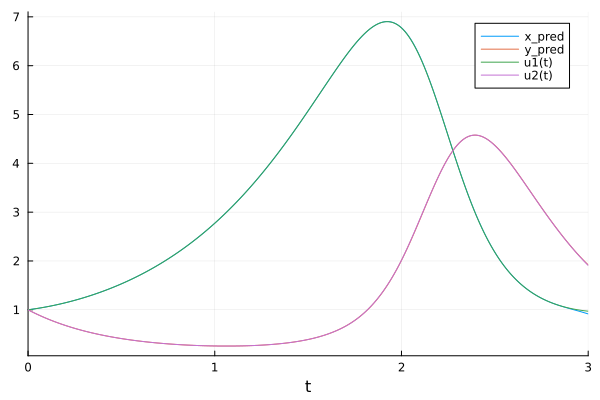

In [27]:
using Plots

phi = pinn.phi
ts = [true_sol.t...;;]
x_pred = phi.x(ts, res.u.x)
y_pred = phi.y(ts, res.u.y)

plot(vec(ts), vec(x_pred), label="x_pred")
plot!(vec(ts), vec(y_pred), label="y_pred")
plot!(true_sol)

In [28]:
maximum(sum(abs2, vcat(x_pred, y_pred) .- stack(true_sol.u); dims=1))

0.0032348473114488427

In [16]:
sampler = remake(sampler; α = 0.8)
data = Sophon.sample(lotka_volterra, sampler)
prob = remake(prob; p = data, u0 = res.u)

res = Optimization.solve(prob, BFGS(); maxiters=2000, callback=callback)

Loss: 0.0036305548916855794
Loss: 0.003438994979550389
Loss: 0.0033031353415787497
Loss: 0.0032454616791083657
Loss: 0.003063783958127952
Loss: 0.0026612131102734444
Loss: 0.002616410806804093
Loss: 0.002346067146779643
Loss: 0.0020835335934140057
Loss: 0.0018293665222978814
Loss: 0.0017408445910052114


Loss: 0.0016016024432065337
Loss: 0.0012688736470224734
Loss: 0.0010930366039123844
Loss: 0.0009840758374167944
Loss: 0.0008810466609586577
Loss: 0.0007235636873493295
Loss: 0.0006445199326254568
Loss: 0.0005596970007087596
Loss: 0.0005161571427281218
Loss: 0.0004767130190444172
Loss: 0.0004149469730365999
Loss: 0.00038828800513234196
Loss: 0.0003103602598585293
Loss: 0.00027179113894700685
Loss: 0.0002434704794964854
Loss: 0.00022004009710895848


Loss: 0.00019974586879916098
Loss: 0.0001829434613309694
Loss: 0.00017475003595665008
Loss: 0.0001686193539122128
Loss: 0.00016116867975695184
Loss: 0.000149329020771853
Loss: 0.00014259842644795645
Loss: 0.00013495863133680723
Loss: 0.00012683757704514382
Loss: 0.00012095673941741469
Loss: 0.00011809510954013147
Loss: 0.00011452078408533726
Loss: 0.00010960256788467509
Loss: 0.0001071826043025167
Loss: 0.00010572934896073993
Loss: 0.00010426979928060953


Loss: 0.00010209331245769115
Loss: 9.690848123699561e-5
Loss: 9.168831479864823e-5
Loss: 8.872846942476572e-5
Loss: 8.547871189629147e-5
Loss: 8.360870278247148e-5
Loss: 8.081677492625769e-5
Loss: 7.625176654395872e-5
Loss: 7.389602360012283e-5
Loss: 7.050999547466606e-5
Loss: 6.688789864785422e-5
Loss: 6.501327731870451e-5
Loss: 6.128081665727579e-5
Loss: 5.9576263381322116e-5
Loss: 5.8383732609457453e-5


Loss: 5.800847393651229e-5
Loss: 5.7331675626101415e-5
Loss: 5.637123524846136e-5
Loss: 5.499317782179427e-5
Loss: 5.391129558070773e-5
Loss: 5.313175676678138e-5
Loss: 5.274534235238406e-5
Loss: 5.1997674691875574e-5
Loss: 5.1293665864995566e-5
Loss: 5.049711273468313e-5
Loss: 4.96040243131118e-5
Loss: 4.832759161863951e-5
Loss: 4.7173418966448554e-5
Loss: 4.597866630409067e-5
Loss: 4.488018945756223e-5


Loss: 4.396910480465289e-5
Loss: 4.32482760989601e-5
Loss: 4.248701127857914e-5
Loss: 4.198145748599916e-5
Loss: 4.1714701498546176e-5
Loss: 4.1526129069253015e-5
Loss: 4.131135404408108e-5
Loss: 4.1152963015766864e-5
Loss: 4.102607417719327e-5
Loss: 4.078920162467695e-5
Loss: 3.9773525104819754e-5
Loss: 3.9047675100535635e-5
Loss: 3.8695111442179217e-5
Loss: 3.8505979674955266e-5


Loss: 3.8164323816751004e-5
Loss: 3.7556840807892214e-5
Loss: 3.647781142420055e-5
Loss: 3.566972069140446e-5
Loss: 3.529423577621066e-5
Loss: 3.4961470261321115e-5
Loss: 3.465868939596329e-5
Loss: 3.433852437985337e-5
Loss: 3.412421222823321e-5
Loss: 3.401112608013558e-5
Loss: 3.3955565139532166e-5
Loss: 3.3896964442572064e-5
Loss: 3.385460136547549e-5
Loss: 3.38083058112183e-5
Loss: 3.3766933663882666e-5
Loss: 3.370839903605017e-5


Loss: 3.363517405769382e-5
Loss: 3.359484726479104e-5
Loss: 3.355025386186097e-5
Loss: 3.351247706026759e-5
Loss: 3.346428297301168e-5
Loss: 3.3377462732483484e-5
Loss: 3.321542608329836e-5
Loss: 3.282358128295574e-5
Loss: 3.2346530682108803e-5
Loss: 3.162643640837097e-5
Loss: 3.113276484069124e-5
Loss: 3.0734868926720494e-5
Loss: 3.0517698546809446e-5
Loss: 3.0346274295661384e-5
Loss: 3.0243280316864957e-5
Loss: 2.9924289723767255e-5


Loss: 2.960841502903149e-5
Loss: 2.937890074925594e-5
Loss: 2.915333617892672e-5
Loss: 2.901570602456236e-5
Loss: 2.894864389197654e-5
Loss: 2.8881061247876884e-5
Loss: 2.8795385754014494e-5
Loss: 2.874047692055081e-5
Loss: 2.8698419145874047e-5
Loss: 2.8660842279159247e-5
Loss: 2.862906162360751e-5
Loss: 2.8576387141859913e-5
Loss: 2.8523298008897037e-5
Loss: 2.849454191055759e-5
Loss: 2.8436010735932512e-5
Loss: 2.836770889751981e-5
Loss: 2.83017309478739e-5


Loss: 2.828068220122744e-5
Loss: 2.8236670838505234e-5
Loss: 2.819224733134942e-5
Loss: 2.8132438231017302e-5
Loss: 2.8079833625115277e-5
Loss: 2.8000330752946905e-5
Loss: 2.791437222955223e-5
Loss: 2.7819587498742833e-5
Loss: 2.773850515225823e-5
Loss: 2.7627112669933833e-5
Loss: 2.7404893797028693e-5
Loss: 2.7205520753890203e-5
Loss: 2.697658586520699e-5
Loss: 2.66366627652072e-5


Loss: 2.644031879589709e-5
Loss: 2.629249447681505e-5
Loss: 2.616570353259386e-5
Loss: 2.607130915155894e-5
Loss: 2.5935536260588468e-5
Loss: 2.5829599048493637e-5
Loss: 2.563324302549638e-5
Loss: 2.5468283571003997e-5
Loss: 2.5263373725023078e-5
Loss: 2.5130071876881527e-5
Loss: 2.5053410844513994e-5
Loss: 2.4965250537971736e-5
Loss: 2.489866675225892e-5
Loss: 2.4768571794417937e-5
Loss: 2.4679945295532117e-5
Loss: 2.4608441275436312e-5


Loss: 2.449802889811729e-5
Loss: 2.433951007361942e-5
Loss: 2.4170762457760103e-5
Loss: 2.4031457183343366e-5
Loss: 2.3981972555844154e-5
Loss: 2.3914044726370697e-5
Loss: 2.3866562126021645e-5
Loss: 2.377679159852976e-5
Loss: 2.359763957871921e-5
Loss: 2.325666260007e-5
Loss: 2.278365564607434e-5
Loss: 2.2640766503856006e-5
Loss: 2.2240411270148644e-5
Loss: 2.2083798358941573e-5
Loss: 2.1918465911179953e-5


Loss: 2.1741166489525512e-5
Loss: 2.155611322655589e-5
Loss: 2.1422844448424834e-5
Loss: 2.131857206457468e-5
Loss: 2.1209641045481536e-5
Loss: 2.111955976061203e-5
Loss: 2.0970652363419473e-5
Loss: 2.0814128696542583e-5
Loss: 2.056520312352314e-5
Loss: 2.0064213677771382e-5
Loss: 1.9715602438177533e-5
Loss: 1.9097853504414663e-5
Loss: 1.8736300069139687e-5
Loss: 1.8447300866831464e-5
Loss: 1.8263312808829615e-5
Loss: 1.808301649874041e-5
Loss: 1.787684192454975e-5


Loss: 1.77860252830764e-5
Loss: 1.7620051517935006e-5
Loss: 1.7512440100120546e-5
Loss: 1.7309937860262975e-5
Loss: 1.7184027761968055e-5
Loss: 1.712170855128258e-5
Loss: 1.7065204601041764e-5
Loss: 1.7041941174606195e-5
Loss: 1.7023613759545868e-5
Loss: 1.699548249749578e-5
Loss: 1.6961775911151748e-5
Loss: 1.692320307630008e-5
Loss: 1.686950897211428e-5
Loss: 1.68158568003411e-5
Loss: 1.6718635801033327e-5
Loss: 1.6600536513218902e-5


Loss: 1.6424300260156132e-5
Loss: 1.6294948422765064e-5
Loss: 1.6178597276881474e-5
Loss: 1.6125203668499548e-5
Loss: 1.6075395358456396e-5
Loss: 1.604428388842508e-5
Loss: 1.6005290130492222e-5
Loss: 1.595645969396131e-5
Loss: 1.5874805338214072e-5
Loss: 1.5830209078258747e-5
Loss: 1.568217809599696e-5
Loss: 1.5589952500371385e-5
Loss: 1.539010146269067e-5
Loss: 1.5276578465898714e-5
Loss: 1.5135200873303405e-5
Loss: 1.5043398007780357e-5
Loss: 1.4881308101492575e-5
Loss: 1.4742077188649138e-5
Loss: 1.4480585163532757e-5


Loss: 1.4274029252511808e-5
Loss: 1.410548308083392e-5
Loss: 1.388876189119053e-5
Loss: 1.3699227271980644e-5
Loss: 1.3545355575490416e-5
Loss: 1.3334270123937644e-5
Loss: 1.3183018355366874e-5
Loss: 1.3113215090167636e-5
Loss: 1.2976489915184056e-5
Loss: 1.2883770673699465e-5
Loss: 1.2769980110402813e-5
Loss: 1.267467884265137e-5
Loss: 1.2542210821816277e-5
Loss: 1.2409835570052305e-5
Loss: 1.2257893141786752e-5
Loss: 1.2151642104519507e-5
Loss: 1.2047684546733814e-5
Loss: 1.1916263318321194e-5
Loss: 1.1795620717155809e-5
Loss: 1.1689847437369599e-5


Loss: 1.1564728660698948e-5
Loss: 1.1467947565700287e-5
Loss: 1.1420002172937615e-5
Loss: 1.138592608804008e-5
Loss: 1.1336167782629114e-5
Loss: 1.1273017216905738e-5
Loss: 1.1235111917039235e-5
Loss: 1.1199161981084723e-5
Loss: 1.1159781769362473e-5
Loss: 1.110185998537478e-5
Loss: 1.1061807726361315e-5
Loss: 1.1026895467529841e-5
Loss: 1.0939992594040608e-5
Loss: 1.0898232647628585e-5
Loss: 1.0794552186688656e-5


Loss: 1.0723335301920083e-5
Loss: 1.055869437374108e-5
Loss: 1.0425185849250902e-5
Loss: 1.0218287090948419e-5
Loss: 1.0126697664681429e-5
Loss: 9.847262133438856e-6
Loss: 9.506989219632037e-6
Loss: 9.328681894178942e-6
Loss: 9.114204873731445e-6
Loss: 9.01800480355343e-6
Loss: 8.956896182385433e-6
Loss: 8.893291825567617e-6
Loss: 8.838462584958315e-6
Loss: 8.758599625969174e-6
Loss: 8.693503933181941e-6


Loss: 8.615055591305007e-6
Loss: 8.52110447292836e-6
Loss: 8.408698756420497e-6
Loss: 8.297178997773462e-6
Loss: 8.184058837936505e-6
Loss: 8.118679124663195e-6
Loss: 8.076342304619632e-6
Loss: 8.050804675137096e-6
Loss: 8.038046843454136e-6
Loss: 8.027154370720547e-6
Loss: 8.020208378294296e-6
Loss: 7.997403049762334e-6
Loss: 7.94245640686719e-6
Loss: 7.865679613479725e-6
Loss: 7.751454173914193e-6


Loss: 7.639356039389783e-6
Loss: 7.514451979215211e-6
Loss: 7.425324421045269e-6
Loss: 7.326152154771675e-6
Loss: 7.168423003613357e-6
Loss: 7.061737212961764e-6
Loss: 6.872484971462705e-6
Loss: 6.756181132253785e-6
Loss: 6.658725614066113e-6
Loss: 6.55852257261595e-6
Loss: 6.506472303793892e-6
Loss: 6.471499477704061e-6
Loss: 6.457995530416101e-6
Loss: 6.44829832718453e-6
Loss: 6.440914928356953e-6
Loss: 6.425427735386532e-6


Loss: 6.411356016523694e-6
Loss: 6.389359474365925e-6
Loss: 6.359225471887184e-6
Loss: 6.340904667752983e-6
Loss: 6.332318154053159e-6
Loss: 6.316034223491689e-6
Loss: 6.298859045867831e-6
Loss: 6.278923546655771e-6
Loss: 6.261265250613221e-6
Loss: 6.227634029171803e-6
Loss: 6.1364206054694065e-6
Loss: 6.055800472154657e-6
Loss: 6.0086967831711435e-6
Loss: 5.954002590175221e-6


Loss: 5.923158882546203e-6
Loss: 5.907109011971655e-6
Loss: 5.899728492619417e-6
Loss: 5.8956269447677425e-6
Loss: 5.8926549301341684e-6
Loss: 5.890369782156197e-6
Loss: 5.889112889290428e-6
Loss: 5.887446018326755e-6
Loss: 5.885146023155662e-6
Loss: 5.883181734365175e-6
Loss: 5.881267891253171e-6
Loss: 5.877444398958843e-6
Loss: 5.86414375573023e-6
Loss: 5.7752018193660005e-6
Loss: 5.6772330197137244e-6


Loss: 5.583265958220232e-6
Loss: 5.477876964236052e-6
Loss: 5.4044283014510615e-6
Loss: 5.327612520299175e-6
Loss: 5.29611967365627e-6
Loss: 5.208555361463292e-6
Loss: 5.102811237677079e-6
Loss: 5.006947006633168e-6
Loss: 4.955730844994326e-6
Loss: 4.924547557302415e-6
Loss: 4.8678193219945246e-6
Loss: 4.8216193574008934e-6
Loss: 4.792342029176022e-6
Loss: 4.761398210213197e-6
Loss: 4.742660204524676e-6
Loss: 4.706230829526367e-6
Loss: 4.693928527222974e-6
Loss: 4.657106426218576e-6


Loss: 4.646131020603241e-6
Loss: 4.625535815614487e-6
Loss: 4.606757223048844e-6
Loss: 4.584451611761676e-6
Loss: 4.554671825975123e-6
Loss: 4.515895659134999e-6
Loss: 4.4933911986569745e-6
Loss: 4.475113496000501e-6
Loss: 4.45894727062981e-6
Loss: 4.4279151687375094e-6
Loss: 4.381771860926655e-6
Loss: 4.337761769951234e-6
Loss: 4.306797154342781e-6
Loss: 4.262137788938045e-6
Loss: 4.196212466883421e-6


Loss: 4.161967844355131e-6
Loss: 4.12745300967567e-6
Loss: 4.096656855117442e-6
Loss: 4.065515477289975e-6
Loss: 4.0449615543496725e-6
Loss: 4.01193258499677e-6
Loss: 3.981093556324829e-6
Loss: 3.939566225614488e-6
Loss: 3.917375927342328e-6
Loss: 3.893300578480764e-6
Loss: 3.867204582853004e-6
Loss: 3.8288234641257455e-6


Loss: 3.7878959482940143e-6
Loss: 3.7460280113337664e-6
Loss: 3.69767522779117e-6
Loss: 3.6348003960594173e-6
Loss: 3.5920340141629107e-6
Loss: 3.5086732490722598e-6
Loss: 3.452256267230461e-6
Loss: 3.3099387614663473e-6
Loss: 3.187814930149522e-6
Loss: 3.132754118426917e-6
Loss: 3.0503163656289154e-6
Loss: 2.991835795642935e-6
Loss: 2.94805674359627e-6
Loss: 2.901669217070615e-6


Loss: 2.8602476442036286e-6
Loss: 2.830201977480317e-6
Loss: 2.8141749805937946e-6
Loss: 2.791599540923389e-6
Loss: 2.768288504090015e-6
Loss: 2.7481203110253298e-6
Loss: 2.7216567872267437e-6
Loss: 2.6932464057346617e-6
Loss: 2.6716125669528096e-6
Loss: 2.6569829288809228e-6
Loss: 2.646660342629797e-6
Loss: 2.6423829272675437e-6
Loss: 2.6402338067077246e-6
Loss: 2.639432918583522e-6
Loss: 2.6387501758985468e-6


Loss: 2.6379137444565707e-6
Loss: 2.6369215810861817e-6
Loss: 2.6339667658546454e-6
Loss: 2.6254748231935694e-6
Loss: 2.61608842835642e-6
Loss: 2.605535520204391e-6
Loss: 2.5925729290583236e-6
Loss: 2.5732273329410975e-6
Loss: 2.5509961782586764e-6
Loss: 2.5330222077409877e-6
Loss: 2.5161849061886154e-6
Loss: 2.4967890353593598e-6
Loss: 2.4767949828890483e-6


Loss: 2.4654254127934602e-6
Loss: 2.4582615301134806e-6
Loss: 2.451426962128369e-6
Loss: 2.4493718758413315e-6
Loss: 2.4477347726932133e-6
Loss: 2.44548595621788e-6
Loss: 2.4387516498413855e-6
Loss: 2.425946437488399e-6
Loss: 2.4168884792257943e-6
Loss: 2.412693118857424e-6
Loss: 2.4094086976695743e-6
Loss: 2.407430589730962e-6
Loss: 2.4046143845845636e-6
Loss: 2.396311954370966e-6


Loss: 2.3811291468182626e-6
Loss: 2.346774321135588e-6
Loss: 2.3220932151695335e-6
Loss: 2.287738054553278e-6
Loss: 2.256476060229167e-6
Loss: 2.188176870138562e-6
Loss: 2.1558096984957497e-6
Loss: 2.137089884937568e-6
Loss: 2.1226188998832668e-6
Loss: 2.1017061654212934e-6
Loss: 2.0945310852063127e-6
Loss: 2.0738484890981656e-6
Loss: 2.065664790198808e-6
Loss: 2.053025986029176e-6
Loss: 2.041632231742021e-6
Loss: 2.034132789152636e-6
Loss: 2.0277953991518716e-6


Loss: 2.0233440677723742e-6
Loss: 2.0212105932887485e-6
Loss: 2.019721100936339e-6
Loss: 2.0179786594496053e-6
Loss: 2.015336537148223e-6
Loss: 2.0099900831766825e-6
Loss: 2.002875726417034e-6
Loss: 1.9987128439318503e-6
Loss: 1.99178328211096e-6
Loss: 1.984219320224536e-6
Loss: 1.975802428442212e-6
Loss: 1.967844714020772e-6
Loss: 1.960946434512683e-6


Loss: 1.9447618242089406e-6
Loss: 1.9296655098337265e-6
Loss: 1.9213871034948225e-6
Loss: 1.9147665317867616e-6
Loss: 1.907701519896848e-6
Loss: 1.901451427688066e-6
Loss: 1.8972645645411516e-6
Loss: 1.8910368737133167e-6
Loss: 1.8840960537614505e-6
Loss: 1.8765094286956189e-6
Loss: 1.8629417479514193e-6
Loss: 1.8496349375960218e-6
Loss: 1.8369072897764692e-6
Loss: 1.8272793935608827e-6
Loss: 1.8114810522197924e-6


Loss: 1.8023094083006572e-6
Loss: 1.789959454988199e-6
Loss: 1.7827394954604788e-6
Loss: 1.7768842701263286e-6
Loss: 1.7735327191218182e-6
Loss: 1.769506506719076e-6
Loss: 1.7643436627560972e-6
Loss: 1.75894695508312e-6
Loss: 1.7538902661868801e-6
Loss: 1.7512504354858299e-6
Loss: 1.749862284777703e-6
Loss: 1.7488285345475497e-6
Loss: 1.7476556728745888e-6
Loss: 1.7461905916625373e-6


Loss: 1.7450978445686457e-6
Loss: 1.7435816617208773e-6
Loss: 1.7426579732516562e-6
Loss: 1.7420015868400069e-6
Loss: 1.7410097098819342e-6
Loss: 1.738251314352727e-6
Loss: 1.7338996852079915e-6
Loss: 1.727146592253141e-6
Loss: 1.7220064228852777e-6
Loss: 1.7168500418546477e-6
Loss: 1.7115012550965351e-6
Loss: 1.7039310375235353e-6


Loss: 1.687274186462726e-6
Loss: 1.6707865883488143e-6
Loss: 1.649088301411095e-6
Loss: 1.632151519650709e-6
Loss: 1.619463112700103e-6
Loss: 1.6045218359868348e-6
Loss: 1.5925279091309997e-6
Loss: 1.5873062578716123e-6
Loss: 1.5768280140698028e-6
Loss: 1.5706454348404522e-6
Loss: 1.5665703463769567e-6
Loss: 1.5630278571228431e-6
Loss: 1.5608730049353152e-6
Loss: 1.559006025795736e-6
Loss: 1.557492643936773e-6
Loss: 1.5563807652530187e-6


Loss: 1.554690567905287e-6
Loss: 1.5514019767497115e-6
Loss: 1.5455884201853897e-6
Loss: 1.5358165005669667e-6
Loss: 1.528215618609641e-6
Loss: 1.5216217167317433e-6
Loss: 1.514293421760754e-6
Loss: 1.5061934284325214e-6
Loss: 1.4938563095967695e-6
Loss: 1.4851762654454078e-6
Loss: 1.477653713187008e-6
Loss: 1.463126465682222e-6


Loss: 1.4586489409226577e-6
Loss: 1.4440533654408512e-6
Loss: 1.4393900398842943e-6
Loss: 1.4287071934902916e-6
Loss: 1.4232543222515649e-6
Loss: 1.4080021371702093e-6
Loss: 1.39651567919627e-6
Loss: 1.3911327698935648e-6
Loss: 1.3809620208009117e-6
Loss: 1.3729199909862298e-6
Loss: 1.370191345893911e-6
Loss: 1.364308620458599e-6
Loss: 1.3550827993256915e-6
Loss: 1.3514075228442558e-6
Loss: 1.3473249904048345e-6
Loss: 1.3429585597379853e-6


Loss: 1.3396149706385148e-6
Loss: 1.333994339844053e-6
Loss: 1.32978844955169e-6
Loss: 1.3269194804277126e-6
Loss: 1.3250551825425113e-6
Loss: 1.32246488299943e-6
Loss: 1.3209103717332772e-6
Loss: 1.318950922163323e-6
Loss: 1.3178595752716504e-6
Loss: 1.3169971479900462e-6
Loss: 1.3161943580335985e-6
Loss: 1.3156205381646042e-6
Loss: 1.314886024244395e-6
Loss: 1.3142274356655802e-6
Loss: 1.3128743052313177e-6


Loss: 1.3110985452813644e-6
Loss: 1.3090745269212678e-6
Loss: 1.3078459444370876e-6
Loss: 1.306819258000259e-6
Loss: 1.3050275601382796e-6
Loss: 1.3024390189478668e-6
Loss: 1.3003923912858676e-6
Loss: 1.2973158629145322e-6
Loss: 1.29283233198271e-6
Loss: 1.2867782142799176e-6
Loss: 1.282079462920325e-6
Loss: 1.27545705000731e-6
Loss: 1.2687958020643595e-6
Loss: 1.2589828709624798e-6


Loss: 1.2528155474316851e-6
Loss: 1.2478738008643844e-6
Loss: 1.2455522021428655e-6
Loss: 1.2427487525081927e-6
Loss: 1.2410684281376512e-6
Loss: 1.2399679139536299e-6
Loss: 1.2391926116882877e-6
Loss: 1.2382774795871984e-6
Loss: 1.2361274185238086e-6
Loss: 1.2319512117959685e-6
Loss: 1.227599266554185e-6
Loss: 1.2238129130837978e-6
Loss: 1.215912766391654e-6
Loss: 1.2047675997555339e-6


Loss: 1.2011396135529e-6
Loss: 1.1961875176038695e-6
Loss: 1.188981255160881e-6
Loss: 1.1790723083639897e-6
Loss: 1.1750863440775967e-6
Loss: 1.1694175226331038e-6
Loss: 1.1652010013455393e-6
Loss: 1.160546681141437e-6
Loss: 1.1537202102344385e-6
Loss: 1.1459965093743863e-6
Loss: 1.1357414572311736e-6
Loss: 1.132250870237763e-6
Loss: 1.1230004933254532e-6
Loss: 1.1208385340481493e-6
Loss: 1.115622749665036e-6


Loss: 1.1121108648249454e-6
Loss: 1.1078212952944313e-6
Loss: 1.1052228932596401e-6
Loss: 1.1023179159923657e-6
Loss: 1.1015093818534022e-6
Loss: 1.1003016423730563e-6
Loss: 1.0989519151226664e-6
Loss: 1.0968765433555723e-6
Loss: 1.093401717040717e-6
Loss: 1.0889617350544814e-6
Loss: 1.0834020758349505e-6
Loss: 1.0762818696202678e-6
Loss: 1.0667708367013674e-6
Loss: 1.0502375667770558e-6
Loss: 1.0295266137528752e-6


Loss: 1.0067682312226234e-6
Loss: 9.96444108180381e-7
Loss: 9.604550832370116e-7
Loss: 9.231286846487819e-7
Loss: 9.024788385863721e-7
Loss: 8.819315799365539e-7
Loss: 8.697118392103521e-7
Loss: 8.52592090422401e-7
Loss: 8.433752405503438e-7
Loss: 8.360825009379462e-7
Loss: 8.317304477640972e-7
Loss: 8.269162017717544e-7
Loss: 8.230403299807192e-7
Loss: 8.203099639633355e-7
Loss: 8.185790464901513e-7
Loss: 8.142698111360521e-7
Loss: 8.10441952673299e-7


Loss: 8.064990836667072e-7
Loss: 8.018533440249988e-7
Loss: 7.967536807964779e-7
Loss: 7.932121976965876e-7
Loss: 7.893759786745336e-7
Loss: 7.850268677520339e-7
Loss: 7.812120831811397e-7
Loss: 7.775057689710429e-7
Loss: 7.740558761465003e-7
Loss: 7.702973404439689e-7
Loss: 7.683282988851554e-7
Loss: 7.639075242528337e-7
Loss: 7.612698384713573e-7
Loss: 7.585856308236899e-7
Loss: 7.568241796764506e-7
Loss: 7.550292747439641e-7


Loss: 7.519455578793842e-7
Loss: 7.493472617259598e-7
Loss: 7.465982236965359e-7
Loss: 7.438579348007719e-7
Loss: 7.416248938863648e-7
Loss: 7.404558802685084e-7
Loss: 7.39152966771159e-7
Loss: 7.382274527213048e-7
Loss: 7.377463640124614e-7
Loss: 7.374763437344689e-7
Loss: 7.367172395560519e-7
Loss: 7.355825086968147e-7
Loss: 7.34942183983423e-7
Loss: 7.346268085770749e-7
Loss: 7.342490538097738e-7


Loss: 7.33220501779583e-7
Loss: 7.305578322735984e-7
Loss: 7.256544909782229e-7
Loss: 7.220375511701014e-7
Loss: 7.206370489140503e-7
Loss: 7.189946817224168e-7
Loss: 7.176934693601442e-7
Loss: 7.147705236995288e-7
Loss: 7.126976483595133e-7
Loss: 7.117166316797412e-7
Loss: 7.095329797950073e-7
Loss: 7.038635356142527e-7
Loss: 6.963357209728312e-7
Loss: 6.872177724684046e-7
Loss: 6.819058465653359e-7


Loss: 6.658418357590426e-7
Loss: 6.58717964690611e-7
Loss: 6.523597741373259e-7
Loss: 6.46796092283778e-7
Loss: 6.41605146709629e-7
Loss: 6.369182187054284e-7
Loss: 6.246588532971678e-7
Loss: 6.176764668707095e-7
Loss: 6.081187992935738e-7
Loss: 6.05687089697195e-7
Loss: 5.954433769816988e-7
Loss: 5.87746380259373e-7
Loss: 5.835473775027455e-7
Loss: 5.791631668962549e-7
Loss: 5.76361340984372e-7
Loss: 5.709952176097657e-7
Loss: 5.68238237850659e-7
Loss: 5.648894391238447e-7
Loss: 5.600719248939254e-7


Loss: 5.546195841879083e-7
Loss: 5.516763703684573e-7
Loss: 5.469678296340646e-7
Loss: 5.452290339836623e-7
Loss: 5.429239319674934e-7
Loss: 5.41995606630877e-7
Loss: 5.412090635515743e-7
Loss: 5.402666229853648e-7
Loss: 5.390009453144887e-7
Loss: 5.379578624636438e-7
Loss: 5.371804615631545e-7
Loss: 5.365757375857544e-7
Loss: 5.359134307061941e-7
Loss: 5.353671451879936e-7
Loss: 5.349476278937592e-7
Loss: 5.345453614176875e-7


Loss: 5.342170080802531e-7
Loss: 5.340323292718211e-7
Loss: 5.338764214638403e-7
Loss: 5.336877211468241e-7
Loss: 5.333621151079904e-7
Loss: 5.33231129747789e-7
Loss: 5.32915572227482e-7
Loss: 5.327219460761558e-7
Loss: 5.325461325389021e-7
Loss: 5.324065593807701e-7
Loss: 5.32037062369547e-7
Loss: 5.303819691815048e-7
Loss: 5.280151714014403e-7


Loss: 5.256817389012911e-7
Loss: 5.241268969822589e-7
Loss: 5.222933816134188e-7
Loss: 5.205419230337609e-7
Loss: 5.18552927504385e-7
Loss: 5.164393499521708e-7
Loss: 5.14651674116424e-7
Loss: 5.100977895072424e-7
Loss: 5.088138022846791e-7
Loss: 5.039943233808181e-7
Loss: 5.02078665131868e-7
Loss: 4.948666259331397e-7
Loss: 4.923846668166081e-7
Loss: 4.89378861302503e-7
Loss: 4.883924911370373e-7
Loss: 4.875444704579598e-7
Loss: 4.866930171870644e-7


Loss: 4.857416151749954e-7
Loss: 4.847249310367845e-7
Loss: 4.823636316127167e-7
Loss: 4.783361259394228e-7
Loss: 4.769755836040091e-7
Loss: 4.744906377160037e-7
Loss: 4.7346245155547653e-7
Loss: 4.716623528371798e-7
Loss: 4.700580395751655e-7
Loss: 4.684345393877529e-7
Loss: 4.661495620326505e-7
Loss: 4.635634730822573e-7
Loss: 4.6273125241947433e-7
Loss: 4.614957599080572e-7
Loss: 4.6028963061719043e-7


Loss: 4.5832946054829544e-7
Loss: 4.5577074373939635e-7
Loss: 4.5442807888517097e-7
Loss: 4.527711518830168e-7
Loss: 4.506425161094311e-7
Loss: 4.4962294401746265e-7
Loss: 4.4852756898112824e-7
Loss: 4.460238462459262e-7
Loss: 4.439503583309436e-7
Loss: 4.404227529549946e-7
Loss: 4.3804184689110433e-7
Loss: 4.356120048916898e-7
Loss: 4.3334654241094757e-7
Loss: 4.31819493503866e-7
Loss: 4.2973861598564066e-7
Loss: 4.287114979752769e-7


Loss: 4.2688029239079117e-7
Loss: 4.254184248283919e-7
Loss: 4.225533396570406e-7
Loss: 4.208991141492073e-7
Loss: 4.1935992587156584e-7
Loss: 4.1838988371491865e-7
Loss: 4.1661625038206653e-7
Loss: 4.147412950995892e-7
Loss: 4.124629561541238e-7
Loss: 4.085068340292121e-7
Loss: 4.033448725117061e-7
Loss: 4.0259082186552444e-7
Loss: 3.992950772507985e-7


Loss: 3.9829709621290953e-7
Loss: 3.9679307884584905e-7
Loss: 3.9632418702149853e-7
Loss: 3.9504648190850994e-7
Loss: 3.9420403411269344e-7
Loss: 3.9300407868805826e-7
Loss: 3.9144959396853853e-7
Loss: 3.900870397191723e-7
Loss: 3.890105066530504e-7
Loss: 3.877976560162619e-7
Loss: 3.8697454629914176e-7
Loss: 3.8624627886434885e-7
Loss: 3.8600144199563003e-7
Loss: 3.858471533565901e-7


Loss: 3.8576537840124825e-7
Loss: 3.855766197366423e-7
Loss: 3.8516476544596525e-7
Loss: 3.848146158336236e-7
Loss: 3.844611034775268e-7
Loss: 3.837745004200656e-7
Loss: 3.8294918190341513e-7
Loss: 3.8224498808646994e-7
Loss: 3.81466798545336e-7
Loss: 3.8102112852907014e-7
Loss: 3.807106275859678e-7
Loss: 3.8047764520944786e-7


Loss: 3.7976613797499827e-7
Loss: 3.786900108062005e-7
Loss: 3.776258146184284e-7
Loss: 3.773033108059687e-7
Loss: 3.771065262561095e-7
Loss: 3.7693131661451783e-7
Loss: 3.764667911617561e-7
Loss: 3.762312192013442e-7
Loss: 3.760509746803662e-7
Loss: 3.7562717785655377e-7
Loss: 3.7419970084592934e-7
Loss: 3.7159798384701474e-7
Loss: 3.693870261246835e-7


Loss: 3.6615848119466843e-7
Loss: 3.6243199945722446e-7
Loss: 3.6032507309936445e-7
Loss: 3.5820261192659037e-7
Loss: 3.570387695609954e-7
Loss: 3.5315016158913387e-7
Loss: 3.4781127520123995e-7
Loss: 3.38346893731159e-7
Loss: 3.3263224858818554e-7
Loss: 3.247129386526513e-7
Loss: 3.2044707915823066e-7
Loss: 3.1518877712967007e-7
Loss: 3.1022127180527866e-7
Loss: 3.060707235975237e-7
Loss: 3.0100476733108315e-7
Loss: 2.994206655762209e-7


Loss: 2.980422436826839e-7
Loss: 2.971926667302914e-7
Loss: 2.9625593367736415e-7
Loss: 2.9493612466938355e-7
Loss: 2.9376549380855475e-7
Loss: 2.9186380471257753e-7
Loss: 2.9102147329789356e-7
Loss: 2.890791140650644e-7
Loss: 2.872246870523164e-7
Loss: 2.8641840678236525e-7
Loss: 2.858881029738932e-7
Loss: 2.853126631011819e-7
Loss: 2.8476966138807303e-7
Loss: 2.842543444554921e-7


Loss: 2.8377715846947037e-7
Loss: 2.8332719970865343e-7
Loss: 2.829507131228072e-7
Loss: 2.8242030881718193e-7
Loss: 2.8126444171356923e-7
Loss: 2.791424713322989e-7
Loss: 2.765721568705059e-7
Loss: 2.7540732430243e-7
Loss: 2.7524194639893376e-7
Loss: 2.7447209636427814e-7
Loss: 2.7380645437754285e-7
Loss: 2.728209801225949e-7


Loss: 2.720083774932626e-7
Loss: 2.7153032974417083e-7
Loss: 2.709523911260446e-7
Loss: 2.7056719346314735e-7
Loss: 2.7016749688249246e-7
Loss: 2.6934126131677536e-7
Loss: 2.686555720583221e-7
Loss: 2.682446678179928e-7
Loss: 2.680153944946608e-7
Loss: 2.678851822069848e-7
Loss: 2.67772626615837e-7
Loss: 2.676322639754027e-7


Loss: 2.674625206114918e-7
Loss: 2.672410793159979e-7
Loss: 2.669205418073723e-7
Loss: 2.6655373237931464e-7
Loss: 2.663680473711825e-7
Loss: 2.662217138820662e-7
Loss: 2.6618163302456423e-7
Loss: 2.6616934069830216e-7


Loss: 2.661641330481599e-7
Loss: 2.6615751937940924e-7
Loss: 2.661465158038685e-7
Loss: 2.661288198183908e-7
Loss: 2.660903457642299e-7
Loss: 2.6601766098895197e-7
Loss: 2.658973583401745e-7
Loss: 2.6560057136902076e-7
Loss: 2.651977346551742e-7
Loss: 2.649366063161879e-7
Loss: 2.6468524860232676e-7


Loss: 2.64346473585877e-7
Loss: 2.6423678930206994e-7
Loss: 2.6412304118689955e-7
Loss: 2.640635239449414e-7
Loss: 2.640386628010783e-7
Loss: 2.6402817280529773e-7
Loss: 2.6400957241274584e-7
Loss: 2.6396734771600374e-7
Loss: 2.6392348101845714e-7
Loss: 2.6390515099108373e-7
Loss: 2.6385518454832676e-7
Loss: 2.637199366926536e-7


Loss: 2.6351794981328376e-7
Loss: 2.6302499890641176e-7
Loss: 2.6230373289604444e-7
Loss: 2.603560705064369e-7
Loss: 2.580054210550484e-7
Loss: 2.5525584602258284e-7
Loss: 2.5196540543297366e-7
Loss: 2.4963603207309054e-7
Loss: 2.489105730149773e-7
Loss: 2.4674116631786483e-7
Loss: 2.4599424522137644e-7
Loss: 2.4462854684727473e-7
Loss: 2.4395988421324957e-7
Loss: 2.4350166385958034e-7


Loss: 2.4301887374432745e-7
Loss: 2.423816055725577e-7
Loss: 2.421357899237294e-7
Loss: 2.416299237317338e-7
Loss: 2.4127949356016704e-7
Loss: 2.4104877308896144e-7
Loss: 2.408753723112902e-7
Loss: 2.4077532776202843e-7
Loss: 2.4068915194704907e-7
Loss: 2.405674976479156e-7
Loss: 2.4042144367068797e-7
Loss: 2.402460197261677e-7


Loss: 2.400774819915428e-7
Loss: 2.399391685989847e-7
Loss: 2.3981136099837575e-7
Loss: 2.3969459227043775e-7
Loss: 2.3962893937135793e-7
Loss: 2.395786821930636e-7
Loss: 2.395492126836853e-7
Loss: 2.3953536387595044e-7
Loss: 2.3952212723582906e-7
Loss: 2.39504591697885e-7
Loss: 2.394833371043471e-7
Loss: 2.394577692027651e-7


Loss: 2.3942951111754286e-7
Loss: 2.3938178847709363e-7
Loss: 2.3927620736676316e-7
Loss: 2.3904257370309523e-7
Loss: 2.3751994810355756e-7
Loss: 2.365007996295471e-7
Loss: 2.3568365627853347e-7
Loss: 2.3513099405487463e-7
Loss: 2.345850884431387e-7
Loss: 2.34126932831175e-7
Loss: 2.3332054723357034e-7
Loss: 2.3266211121663437e-7
Loss: 2.319396312369424e-7


Loss: 2.308128485635629e-7
Loss: 2.3040436167021613e-7
Loss: 2.286981818510306e-7
Loss: 2.279667935209149e-7
Loss: 2.2682323103118115e-7
Loss: 2.259686218044101e-7
Loss: 2.2555058652444321e-7
Loss: 2.244052279050263e-7
Loss: 2.241102827423901e-7
Loss: 2.2313853543457097e-7
Loss: 2.220926850249574e-7
Loss: 2.2074792393848492e-7
Loss: 2.1989518701556898e-7
Loss: 2.1838695873744024e-7
Loss: 2.177027023810714e-7


Loss: 2.1602126653607316e-7
Loss: 2.153324840063359e-7
Loss: 2.141608812385073e-7
Loss: 2.122210652554596e-7
Loss: 2.1060608134315915e-7
Loss: 2.098344725903628e-7
Loss: 2.0810820117372843e-7
Loss: 2.0741593163340655e-7
Loss: 2.059996059931249e-7
Loss: 2.0505760491038858e-7
Loss: 2.0402698572960822e-7
Loss: 2.0313319633013903e-7
Loss: 2.0234328363788013e-7
Loss: 2.0171203641102385e-7
Loss: 2.0080086664238602e-7


Loss: 1.982304001809234e-7
Loss: 1.9453698644309132e-7
Loss: 1.9395196481788653e-7
Loss: 1.9189004754498382e-7
Loss: 1.9030618282140444e-7
Loss: 1.8914314682011142e-7
Loss: 1.8843251197322455e-7
Loss: 1.8792428605501443e-7
Loss: 1.8730101379067975e-7
Loss: 1.8624741545042137e-7
Loss: 1.8500344750020468e-7
Loss: 1.837516343145305e-7
Loss: 1.8280960666390483e-7
Loss: 1.8164882537535997e-7
Loss: 1.8013006457016335e-7


Loss: 1.7892396275525988e-7
Loss: 1.778437399364246e-7
Loss: 1.766041444422714e-7
Loss: 1.7598735510720567e-7
Loss: 1.752792751096394e-7
Loss: 1.744980662849424e-7
Loss: 1.7398083914377463e-7
Loss: 1.7340835974461705e-7
Loss: 1.7287871760924364e-7
Loss: 1.7261723401734177e-7
Loss: 1.7207608265580985e-7
Loss: 1.7137397880294868e-7
Loss: 1.704443738188632e-7
Loss: 1.6938906739533623e-7
Loss: 1.6803336177830447e-7
Loss: 1.6696349671852234e-7
Loss: 1.6598400789787667e-7


Loss: 1.652628824001137e-7
Loss: 1.6477446584672652e-7
Loss: 1.6450170290724416e-7
Loss: 1.6416288522175147e-7
Loss: 1.6377317485888957e-7
Loss: 1.6334289694860038e-7
Loss: 1.6288907208294088e-7
Loss: 1.6236519732943656e-7
Loss: 1.618790243405542e-7
Loss: 1.6160753292620842e-7
Loss: 1.6125315213129976e-7
Loss: 1.6084421532441716e-7
Loss: 1.604550440431783e-7
Loss: 1.601745296062388e-7


Loss: 1.5989234439480144e-7
Loss: 1.5974229545960658e-7
Loss: 1.5952562802101578e-7
Loss: 1.5923859309545468e-7
Loss: 1.5905182805048266e-7
Loss: 1.589558293000749e-7
Loss: 1.5890065066328493e-7
Loss: 1.5886738790363525e-7
Loss: 1.5882200839292068e-7
Loss: 1.5876865829383357e-7
Loss: 1.5870673960210215e-7
Loss: 1.5851855340953314e-7
Loss: 1.5805354503983883e-7
Loss: 1.5777231328818212e-7
Loss: 1.5709981222774607e-7
Loss: 1.564381582951095e-7


Loss: 1.5605175257159925e-7
Loss: 1.5582656564932934e-7
Loss: 1.5567050461059137e-7
Loss: 1.555795198504151e-7
Loss: 1.5550559276306024e-7
Loss: 1.5542785350674765e-7
Loss: 1.5536932055826945e-7
Loss: 1.5531308238499955e-7
Loss: 1.5520703948370164e-7
Loss: 1.55080543007042e-7
Loss: 1.5500557421460244e-7
Loss: 1.5493686090157398e-7
Loss: 1.548496367779997e-7


Loss: 1.5482892123960457e-7
Loss: 1.5482284271605083e-7
Loss: 1.548163904375286e-7
Loss: 1.5480867307166576e-7
Loss: 1.5480149823702154e-7
Loss: 1.5477427653814613e-7
Loss: 1.5467724287504605e-7
Loss: 1.5458881473523486e-7
Loss: 1.5448969881485813e-7
Loss: 1.5437748951954982e-7
Loss: 1.5433348934204798e-7
Loss: 1.543055216952499e-7
Loss: 1.5429734725483297e-7
Loss: 1.5429265058261305e-7


Loss: 1.5428293095261234e-7
Loss: 1.542401681160811e-7
Loss: 1.540369960330243e-7
Loss: 1.5380365954096995e-7
Loss: 1.5370130821759338e-7
Loss: 1.536773764801061e-7
Loss: 1.536692030387143e-7
Loss: 1.536670767304428e-7
Loss: 1.5366617557153833e-7
Loss: 1.5366472492233873e-7
Loss: 1.5365175510494602e-7
Loss: 1.5354682379477566e-7
Loss: 1.5337756748685622e-7


Loss: 1.5320462206159712e-7
Loss: 1.5312326240895575e-7
Loss: 1.528803869393707e-7
Loss: 1.524959859810154e-7
Loss: 1.5198250591984824e-7
Loss: 1.5182595340199973e-7
Loss: 1.5140545602688013e-7
Loss: 1.5117378673652404e-7
Loss: 1.5028600413301272e-7
Loss: 1.4985024847781466e-7
Loss: 1.486196401387216e-7
Loss: 1.4737291699533888e-7
Loss: 1.4709518035197776e-7
Loss: 1.4636932731442273e-7
Loss: 1.4569162893413563e-7
Loss: 1.4520791774491153e-7


Loss: 1.4467130192566566e-7
Loss: 1.4435004680749986e-7
Loss: 1.4397318496876087e-7
Loss: 1.4323589365201617e-7
Loss: 1.4282391995732845e-7
Loss: 1.4229077965522195e-7
Loss: 1.4199913392827077e-7
Loss: 1.416719699364719e-7
Loss: 1.412934129417441e-7
Loss: 1.4077426165966585e-7
Loss: 1.405980650716748e-7
Loss: 1.402089716602654e-7
Loss: 1.4002517305728733e-7
Loss: 1.3971403226170013e-7
Loss: 1.395028080372122e-7
Loss: 1.393060137273756e-7
Loss: 1.3907193058528066e-7
Loss: 1.38976487235367e-7
Loss: 1.388776227233567e-7


Loss: 1.3883129087876042e-7
Loss: 1.3876901840251564e-7
Loss: 1.3873532475072704e-7
Loss: 1.3869529063131171e-7
Loss: 1.3865514369376759e-7
Loss: 1.3861176717393432e-7
Loss: 1.385585182069787e-7
Loss: 1.3847552425539364e-7
Loss: 1.384085014071093e-7
Loss: 1.3833195535004464e-7
Loss: 1.3824919767990203e-7
Loss: 1.381927218454236e-7
Loss: 1.3816235749208185e-7


Loss: 1.3812777568805504e-7
Loss: 1.3810174598633048e-7
Loss: 1.3807214424495892e-7
Loss: 1.3805241914677547e-7
Loss: 1.3804184159693376e-7
Loss: 1.380325214493645e-7
Loss: 1.3801878279112847e-7
Loss: 1.3799996888199575e-7
Loss: 1.3798769002214003e-7
Loss: 1.3797721192362375e-7
Loss: 1.3795930256517954e-7
Loss: 1.3793224445712042e-7
Loss: 1.378667029322067e-7


Loss: 1.3771534510313838e-7
Loss: 1.3763296223180348e-7
Loss: 1.375993612362001e-7
Loss: 1.3758124036139853e-7
Loss: 1.3757329817118322e-7
Loss: 1.375667745825982e-7
Loss: 1.3756149289132696e-7
Loss: 1.3755528255516282e-7
Loss: 1.3754202012377043e-7
Loss: 1.3752167272854308e-7
Loss: 1.375114866102074e-7
Loss: 1.3750278572798228e-7
Loss: 1.3750001071527612e-7
Loss: 1.3749836968002433e-7


Loss: 1.3749727779343432e-7
Loss: 1.3749562704000288e-7
Loss: 1.3748974591032452e-7
Loss: 1.3746631969739713e-7
Loss: 1.373836242504134e-7
Loss: 1.3726596038591477e-7
Loss: 1.3717754095942828e-7
Loss: 1.3711359126776495e-7
Loss: 1.3704370668614294e-7
Loss: 1.370125919473655e-7
Loss: 1.3699562976160808e-7
Loss: 1.369837564022139e-7
Loss: 1.36968330237228e-7
Loss: 1.3693437001188942e-7
Loss: 1.3684222051030795e-7


Loss: 1.3660894183277254e-7
Loss: 1.3650648105409535e-7
Loss: 1.3607523788970942e-7
Loss: 1.3588212727345697e-7
Loss: 1.3532198320965414e-7
Loss: 1.350735286128668e-7
Loss: 1.3473144809492815e-7
Loss: 1.339997897340396e-7
Loss: 1.3362459622436428e-7
Loss: 1.3322033109544048e-7
Loss: 1.328655887891525e-7
Loss: 1.319442701779155e-7
Loss: 1.311772330332138e-7
Loss: 1.302588835185887e-7
Loss: 1.2997530774048544e-7


Loss: 1.292442379028556e-7
Loss: 1.2886170390722791e-7
Loss: 1.281566399831186e-7
Loss: 1.2750974315562357e-7
Loss: 1.271309415947515e-7
Loss: 1.2697073968416406e-7
Loss: 1.2683497931615863e-7
Loss: 1.2672219859301003e-7
Loss: 1.2663718461555412e-7
Loss: 1.265612061751328e-7
Loss: 1.2646339642174672e-7
Loss: 1.2637819619242182e-7
Loss: 1.2626882828469316e-7
Loss: 1.261787214757135e-7
Loss: 1.261080982151497e-7
Loss: 1.2600333014008538e-7
Loss: 1.259234661296739e-7


Loss: 1.2584799306886092e-7
Loss: 1.257990557162143e-7
Loss: 1.2573452428193963e-7
Loss: 1.2561653177185173e-7
Loss: 1.2547943769563002e-7
Loss: 1.2530522428190142e-7
Loss: 1.2521799758584363e-7
Loss: 1.2517520814856065e-7
Loss: 1.251560326080062e-7
Loss: 1.2514505635023745e-7
Loss: 1.2513199418095246e-7
Loss: 1.2511688681329746e-7


Loss: 1.2508701503444503e-7
Loss: 1.2504790330457099e-7
Loss: 1.2498041812951457e-7
Loss: 1.2490578349473792e-7
Loss: 1.2481478379816743e-7
Loss: 1.2466787142963965e-7
Loss: 1.2444201347538672e-7
Loss: 1.243719730068559e-7
Loss: 1.2421828920297707e-7
Loss: 1.241980203142305e-7
Loss: 1.2417910167125163e-7
Loss: 1.2416422745786472e-7


Loss: 1.241556860364098e-7
Loss: 1.2414941494290953e-7
Loss: 1.2414531579491012e-7
Loss: 1.241436995266595e-7
Loss: 1.2414140315001542e-7
Loss: 1.2413542918443368e-7
Loss: 1.2412069251534498e-7
Loss: 1.241124250046046e-7
Loss: 1.2410931896164532e-7
Loss: 1.2410745219377325e-7
Loss: 1.2410276659941314e-7


Loss: 1.2408394074144122e-7
Loss: 1.2405905209223764e-7
Loss: 1.240318206018038e-7
Loss: 1.2399350368686832e-7
Loss: 1.2394591637239685e-7
Loss: 1.2391423112751303e-7
Loss: 1.2387226615907204e-7
Loss: 1.237797976810784e-7
Loss: 1.2368375238222612e-7
Loss: 1.2333992794281773e-7
Loss: 1.2312061473219496e-7
Loss: 1.2285593804487126e-7
Loss: 1.2255913636970272e-7
Loss: 1.2217782442638362e-7


Loss: 1.2169654207041092e-7
Loss: 1.2123156447446346e-7
Loss: 1.2079856188637963e-7
Loss: 1.2032169886966876e-7
Loss: 1.1937675693605252e-7
Loss: 1.1868551588153495e-7
Loss: 1.1818190150802135e-7
Loss: 1.1808942093846339e-7
Loss: 1.175787648861373e-7
Loss: 1.1740092545831304e-7
Loss: 1.1718157280367004e-7
Loss: 1.1697401975456943e-7
Loss: 1.1682799962398854e-7
Loss: 1.1658525699818137e-7
Loss: 1.16360724575241e-7
Loss: 1.1612335431012656e-7
Loss: 1.1592397881669388e-7


Loss: 1.1576677440393333e-7
Loss: 1.1562310769760012e-7
Loss: 1.1540708044420353e-7
Loss: 1.1508653348687682e-7
Loss: 1.1484175476999641e-7
Loss: 1.1466827471458878e-7
Loss: 1.1448119596374547e-7
Loss: 1.1434284426640144e-7
Loss: 1.1426785077987278e-7
Loss: 1.1419091723975328e-7
Loss: 1.141356641989185e-7
Loss: 1.140916085364841e-7
Loss: 1.1404514274444987e-7
Loss: 1.139887938518772e-7
Loss: 1.1395509437889359e-7
Loss: 1.1391639978380558e-7
Loss: 1.1384827597691268e-7


Loss: 1.1378581003418098e-7
Loss: 1.1371783524603537e-7
Loss: 1.136580075058168e-7
Loss: 1.135942212394059e-7
Loss: 1.1354113759336404e-7
Loss: 1.1342918397214548e-7
Loss: 1.1324613396540591e-7
Loss: 1.1303446749454424e-7
Loss: 1.129754351801131e-7
Loss: 1.1283052290091578e-7
Loss: 1.1273617941097623e-7
Loss: 1.1266348461038821e-7
Loss: 1.1262987889591428e-7
Loss: 1.125711140847521e-7


Loss: 1.125192988425114e-7
Loss: 1.1234861520193099e-7
Loss: 1.118825233817662e-7
Loss: 1.1128878173056468e-7
Loss: 1.1048379497274412e-7
Loss: 1.1021417836697194e-7
Loss: 1.099882645420305e-7
Loss: 1.0943298307057237e-7
Loss: 1.0878291644808684e-7
Loss: 1.081625290722252e-7
Loss: 1.0791297891841552e-7
Loss: 1.076600114915971e-7
Loss: 1.0746014442496476e-7
Loss: 1.0741271410431746e-7


Loss: 1.072884083019093e-7
Loss: 1.071330352656961e-7
Loss: 1.0686543254930226e-7
Loss: 1.0642315775921494e-7
Loss: 1.0625185262309777e-7
Loss: 1.0584947030264095e-7
Loss: 1.0556461690319834e-7
Loss: 1.0523725904888851e-7
Loss: 1.0506133147187717e-7
Loss: 1.047799559736908e-7
Loss: 1.0453557576867986e-7
Loss: 1.0432701670739439e-7
Loss: 1.0406130570830753e-7
Loss: 1.037119322181695e-7


Loss: 1.0351934809335852e-7
Loss: 1.03109105007511e-7
Loss: 1.02930345125863e-7
Loss: 1.0252914977578011e-7
Loss: 1.0214019184108186e-7
Loss: 1.0192870478874225e-7
Loss: 1.0177830233768527e-7
Loss: 1.0167596084828119e-7
Loss: 1.0161477406170662e-7
Loss: 1.0156934469812686e-7
Loss: 1.015340443281542e-7
Loss: 1.0149600380315304e-7
Loss: 1.0147026644807146e-7


Loss: 1.0143156234048873e-7
Loss: 1.0136845614379344e-7
Loss: 1.012809412306325e-7
Loss: 1.0114071367793154e-7
Loss: 1.0102967365776529e-7
Loss: 1.009377905295449e-7
Loss: 1.0083176138768238e-7
Loss: 1.0074748316091633e-7
Loss: 1.007168284100754e-7
Loss: 1.0067673716813795e-7
Loss: 1.0063291028759965e-7
Loss: 1.0055498030186016e-7


Loss: 1.0047293998636877e-7
Loss: 1.0041077850662209e-7
Loss: 1.0034971638908061e-7
Loss: 1.0020910576618034e-7
Loss: 1.0001838369566394e-7
Loss: 9.977071227541099e-8
Loss: 9.957808489258661e-8
Loss: 9.947015242884575e-8
Loss: 9.935574319824912e-8
Loss: 9.927686390872596e-8
Loss: 9.923182055540424e-8
Loss: 9.917893867677168e-8


Loss: 9.914337923184e-8
Loss: 9.910713418432886e-8
Loss: 9.908628802819645e-8
Loss: 9.907472284692125e-8
Loss: 9.906854419137913e-8
Loss: 9.906295078782759e-8
Loss: 9.905461435610052e-8
Loss: 9.904480596615501e-8
Loss: 9.902831774196321e-8
Loss: 9.901258310433352e-8
Loss: 9.8995766290583e-8
Loss: 9.89806319212714e-8
Loss: 9.89471487978372e-8


Loss: 9.89185609749812e-8
Loss: 9.890500313649638e-8
Loss: 9.88732490236884e-8
Loss: 9.879984778820668e-8
Loss: 9.874229419816477e-8
Loss: 9.86959499644946e-8
Loss: 9.86703300225687e-8
Loss: 9.866023231355254e-8
Loss: 9.865631459768922e-8
Loss: 9.865449970195991e-8
Loss: 9.865311413125898e-8
Loss: 9.865067827447611e-8


Loss: 9.864590153195231e-8
Loss: 9.863760134858968e-8
Loss: 9.862985754279187e-8
Loss: 9.861936564617837e-8
Loss: 9.860836732608288e-8
Loss: 9.859552840600671e-8
Loss: 9.858666573466534e-8
Loss: 9.856766340024796e-8
Loss: 9.851616456776848e-8
Loss: 9.843560420153671e-8
Loss: 9.838237826010874e-8
Loss: 9.83223788790167e-8


Loss: 9.829237795318817e-8
Loss: 9.827673354756555e-8
Loss: 9.826296121388269e-8
Loss: 9.824833567134674e-8
Loss: 9.823550172229591e-8
Loss: 9.822141627911928e-8
Loss: 9.820026501580777e-8
Loss: 9.81710678276933e-8
Loss: 9.812621506093661e-8
Loss: 9.805697841797325e-8
Loss: 9.794816587863727e-8
Loss: 9.787150577691308e-8
Loss: 9.783523621990193e-8


Loss: 9.776395819674677e-8
Loss: 9.771564549640041e-8
Loss: 9.76758298224355e-8
Loss: 9.763276874921354e-8
Loss: 9.758165016733315e-8
Loss: 9.752959755479507e-8
Loss: 9.746615662150967e-8
Loss: 9.74334028416151e-8
Loss: 9.742314908126248e-8
Loss: 9.741596891433506e-8
Loss: 9.740999894981184e-8
Loss: 9.740500576370714e-8
Loss: 9.739268067423256e-8
Loss: 9.738134097026992e-8


Loss: 9.737021015637708e-8
Loss: 9.736066647928207e-8
Loss: 9.735008233157331e-8
Loss: 9.732115344908551e-8
Loss: 9.72986583336451e-8
Loss: 9.729039075849722e-8
Loss: 9.728777887968932e-8
Loss: 9.728444176024595e-8
Loss: 9.728129348655706e-8
Loss: 9.727820095027074e-8
Loss: 9.727625947604634e-8
Loss: 9.72732483645565e-8


Loss: 9.72699168839361e-8
Loss: 9.726576163142583e-8
Loss: 9.725938091684636e-8
Loss: 9.725373908689267e-8
Loss: 9.723987184661573e-8
Loss: 9.721400190480156e-8
Loss: 9.717565350544736e-8
Loss: 9.713312248231923e-8
Loss: 9.708292351043769e-8
Loss: 9.68658190842253e-8
Loss: 9.616790708973692e-8
Loss: 9.585385701528719e-8


Loss: 9.538728618049015e-8
Loss: 9.516952336121175e-8
Loss: 9.495812813314501e-8
Loss: 9.451015980631965e-8
Loss: 9.415591186262076e-8
Loss: 9.379352250334741e-8
Loss: 9.358183377307629e-8
Loss: 9.34130255164456e-8
Loss: 9.311591599513534e-8
Loss: 9.285679889731044e-8
Loss: 9.27078049222438e-8
Loss: 9.230745593808018e-8
Loss: 9.222810333724623e-8
Loss: 9.202124804740953e-8
Loss: 9.192431598967688e-8
Loss: 9.186327473148656e-8
Loss: 9.177182538950947e-8


Loss: 9.170589490340756e-8
Loss: 9.162433388182327e-8
Loss: 9.157540577059135e-8
Loss: 9.152019482564828e-8
Loss: 9.141757381268726e-8
Loss: 9.126025847560872e-8
Loss: 9.101714721424894e-8
Loss: 9.082934457564861e-8
Loss: 9.069384412701922e-8
Loss: 9.055210437903174e-8
Loss: 9.04663824923717e-8
Loss: 9.041935807623364e-8
Loss: 9.037155296988371e-8
Loss: 9.034759422558954e-8
Loss: 9.032862051726294e-8
Loss: 9.029457911631796e-8
Loss: 9.024789247969118e-8


Loss: 9.01924637143158e-8
Loss: 9.01360062614888e-8
Loss: 9.010508665400786e-8
Loss: 9.0072096998273e-8
Loss: 9.002925663113082e-8
Loss: 8.998415073496389e-8
Loss: 8.994871975985297e-8
Loss: 8.989828093924876e-8
Loss: 8.987389020472428e-8
Loss: 8.9848573689937e-8
Loss: 8.982571944670425e-8
Loss: 8.98057632958088e-8
Loss: 8.979216307646661e-8
Loss: 8.977857531762283e-8
Loss: 8.975897544318488e-8
Loss: 8.973839700479543e-8


Loss: 8.970508984085539e-8
Loss: 8.96332162229774e-8
Loss: 8.954847679820767e-8
Loss: 8.950552529738073e-8
Loss: 8.948201002652557e-8
Loss: 8.946111334035223e-8
Loss: 8.944143710242441e-8
Loss: 8.941141186336922e-8
Loss: 8.939677580842462e-8
Loss: 8.938950904376446e-8
Loss: 8.938235803721335e-8


Loss: 8.937610403887796e-8
Loss: 8.936681841356636e-8
Loss: 8.934232556451302e-8
Loss: 8.928586939217998e-8
Loss: 8.924257333624468e-8
Loss: 8.922197955175606e-8
Loss: 8.918037563417944e-8
Loss: 8.911013379738479e-8
Loss: 8.906066141033015e-8
Loss: 8.903310075671083e-8
Loss: 8.8994635927382e-8
Loss: 8.89817410817487e-8
Loss: 8.897510544000249e-8
Loss: 8.897248934471427e-8


Loss: 8.896896535975866e-8
Loss: 8.896411131514443e-8
Loss: 8.895393917800763e-8
Loss: 8.893814622706579e-8
Loss: 8.890092635377184e-8
Loss: 8.884756598544307e-8
Loss: 8.878646701386627e-8
Loss: 8.872310316446245e-8
Loss: 8.868696795356542e-8
Loss: 8.861636737486144e-8
Loss: 8.857823772135629e-8
Loss: 8.850933322527591e-8
Loss: 8.848294891083107e-8


Loss: 8.845344399418401e-8
Loss: 8.84391435320776e-8
Loss: 8.842615403696696e-8
Loss: 8.841309209557183e-8
Loss: 8.840637659938377e-8
Loss: 8.839725868287397e-8
Loss: 8.838304156760858e-8
Loss: 8.837095985808097e-8
Loss: 8.83614398689985e-8
Loss: 8.835380153514303e-8
Loss: 8.834542658449588e-8
Loss: 8.833235798857917e-8


Loss: 8.831955394302239e-8
Loss: 8.830939987095757e-8
Loss: 8.828844666064433e-8
Loss: 8.825920424302285e-8
Loss: 8.82135347072976e-8
Loss: 8.817623571036184e-8
Loss: 8.810915649134102e-8
Loss: 8.803834942034835e-8
Loss: 8.791491082734862e-8
Loss: 8.777170182383808e-8
Loss: 8.768050595964841e-8
Loss: 8.753830392124244e-8


Loss: 8.745876715330155e-8
Loss: 8.73503692910317e-8
Loss: 8.724332206872126e-8
Loss: 8.71294851721739e-8
Loss: 8.707840415793041e-8
Loss: 8.699763016781221e-8
Loss: 8.693561982738918e-8
Loss: 8.682548219873522e-8
Loss: 8.667245788496179e-8
Loss: 8.64232380912704e-8
Loss: 8.629908880704968e-8
Loss: 8.621209284098081e-8
Loss: 8.608964011140579e-8


Loss: 8.603450375646964e-8
Loss: 8.597097406049522e-8
Loss: 8.58378139546945e-8
Loss: 8.572459594990122e-8
Loss: 8.548915258834885e-8
Loss: 8.533899583757456e-8
Loss: 8.52934991170213e-8
Loss: 8.513672014122045e-8
Loss: 8.501861466510616e-8
Loss: 8.487014639294223e-8
Loss: 8.479188234747607e-8
Loss: 8.469535090219097e-8
Loss: 8.459360544897775e-8
Loss: 8.453021432414562e-8
Loss: 8.44718605402639e-8
Loss: 8.440521562931466e-8


Loss: 8.436506380091194e-8
Loss: 8.433342682003125e-8
Loss: 8.426705101545669e-8
Loss: 8.422192228531675e-8
Loss: 8.417488305628816e-8
Loss: 8.411546280339847e-8
Loss: 8.403934279170388e-8
Loss: 8.397616740650241e-8
Loss: 8.392459737345876e-8
Loss: 8.390498731503875e-8
Loss: 8.388795738287657e-8
Loss: 8.387428482988606e-8
Loss: 8.383535439158059e-8


Loss: 8.378397961267195e-8
Loss: 8.3749227519569e-8
Loss: 8.37335216625151e-8
Loss: 8.371224662308523e-8
Loss: 8.36940154973615e-8
Loss: 8.368786894998878e-8
Loss: 8.368375266154082e-8
Loss: 8.367679759521964e-8
Loss: 8.366377206202308e-8
Loss: 8.36588242920817e-8
Loss: 8.3657047489538e-8
Loss: 8.365588217828785e-8


Loss: 8.365460287251478e-8
Loss: 8.365181560569324e-8
Loss: 8.3650122135425e-8
Loss: 8.364920465882198e-8
Loss: 8.36456507400015e-8
Loss: 8.363336230756717e-8
Loss: 8.362419603955566e-8
Loss: 8.362017567626379e-8
Loss: 8.361795970787816e-8
Loss: 8.361375652702977e-8
Loss: 8.360513313293708e-8
Loss: 8.359953774919103e-8


Loss: 8.35970147750717e-8
Loss: 8.35949698201532e-8
Loss: 8.35934291248243e-8
Loss: 8.359240711407863e-8
Loss: 8.359170093568182e-8
Loss: 8.359127601535685e-8
Loss: 8.359076687711541e-8
Loss: 8.358990477630958e-8
Loss: 8.358683784442359e-8
Loss: 8.358150575783661e-8
Loss: 8.357930806837945e-8


Loss: 8.357878688405913e-8
Loss: 8.357847380626741e-8
Loss: 8.357756274430689e-8
Loss: 8.357149701496768e-8
Loss: 8.354586430744512e-8
Loss: 8.351414400142378e-8
Loss: 8.348831427909137e-8
Loss: 8.348140324975407e-8
Loss: 8.34755944447013e-8
Loss: 8.347256401426696e-8
Loss: 8.346898879886844e-8
Loss: 8.346556001262415e-8
Loss: 8.346048088145405e-8
Loss: 8.345712085358038e-8


Loss: 8.345444407770049e-8
Loss: 8.345338834800116e-8
Loss: 8.345241941843137e-8
Loss: 8.345182245933243e-8
Loss: 8.345130499245551e-8
Loss: 8.345100305220138e-8
Loss: 8.345086576899943e-8
Loss: 8.34507783888869e-8
Loss: 8.345070678502605e-8
Loss: 8.345059055397633e-8
Loss: 8.345044939006248e-8
Loss: 8.345031022844151e-8
Loss: 8.345010370268449e-8
Loss: 8.344966897902769e-8
Loss: 8.344857677097376e-8


Loss: 8.344208501493736e-8
Loss: 8.341349233706913e-8
Loss: 8.336430916789064e-8
Loss: 8.318108331835365e-8
Loss: 8.305701103652542e-8
Loss: 8.299896289943797e-8
Loss: 8.282019179523826e-8
Loss: 8.271953510199916e-8
Loss: 8.266032534457966e-8
Loss: 8.257723633900541e-8
Loss: 8.243392948727206e-8
Loss: 8.240587803442763e-8
Loss: 8.224957082894316e-8
Loss: 8.219673057799587e-8
Loss: 8.206251019250879e-8
Loss: 8.200968046576324e-8


Loss: 8.191205004813369e-8
Loss: 8.183473564247382e-8
Loss: 8.170287912037534e-8
Loss: 8.160638056001228e-8
Loss: 8.14885144738579e-8
Loss: 8.139201739976118e-8
Loss: 8.128544107239133e-8
Loss: 8.12487196605986e-8
Loss: 8.11587060081556e-8
Loss: 8.109949200453138e-8
Loss: 8.09922933801049e-8
Loss: 8.094795544504628e-8
Loss: 8.082423254229636e-8
Loss: 8.073324147425115e-8
Loss: 8.060617581080335e-8
Loss: 8.057285368855765e-8


Loss: 8.048392545802887e-8
Loss: 8.040015045676074e-8
Loss: 8.03348989688911e-8
Loss: 8.027089110162098e-8
Loss: 8.018339535212261e-8
Loss: 8.009137763352314e-8
Loss: 7.9963043332678e-8
Loss: 7.987247814126867e-8
Loss: 7.980671804795111e-8
Loss: 7.974861129397464e-8
Loss: 7.967092684934202e-8
Loss: 7.959607283346298e-8
Loss: 7.941745498912141e-8
Loss: 7.937834874442903e-8


Loss: 7.924684802829078e-8
Loss: 7.920630338213195e-8
Loss: 7.913356010476207e-8
Loss: 7.908490163661465e-8
Loss: 7.903674032398365e-8
Loss: 7.889379594113611e-8
Loss: 7.880470252857829e-8
Loss: 7.875388389068559e-8
Loss: 7.87049935949593e-8
Loss: 7.864381453459473e-8
Loss: 7.85890042370272e-8
Loss: 7.85207584087294e-8
Loss: 7.847546248595425e-8
Loss: 7.839840118808328e-8


Loss: 7.836423190753552e-8
Loss: 7.832423907407884e-8
Loss: 7.829795271229124e-8
Loss: 7.822581116358607e-8
Loss: 7.812589507296387e-8
Loss: 7.802703825882989e-8
Loss: 7.792885631413639e-8
Loss: 7.781975172610495e-8
Loss: 7.773956005571147e-8
Loss: 7.763576977921648e-8


Loss: 7.759955308124201e-8
Loss: 7.755240771314991e-8
Loss: 7.752842826069019e-8
Loss: 7.750195717174953e-8
Loss: 7.746961597207364e-8
Loss: 7.743145130369814e-8
Loss: 7.734131548773333e-8
Loss: 7.724561542463124e-8
Loss: 7.7189094876187e-8
Loss: 7.711126475249397e-8
Loss: 7.708872411714916e-8
Loss: 7.707273138250668e-8
Loss: 7.704895607442331e-8


Loss: 7.70015705149738e-8
Loss: 7.690464629154276e-8
Loss: 7.68480342471763e-8
Loss: 7.678990555880185e-8
Loss: 7.675697171152504e-8
Loss: 7.67442934257005e-8
Loss: 7.673710760866962e-8
Loss: 7.672162947850504e-8
Loss: 7.669678221145412e-8
Loss: 7.667870336185277e-8
Loss: 7.666781981888678e-8
Loss: 7.665509949712902e-8
Loss: 7.664563773721975e-8


Loss: 7.662640292229201e-8
Loss: 7.660818328799504e-8
Loss: 7.659404277420606e-8
Loss: 7.657572519684302e-8
Loss: 7.65529144486137e-8
Loss: 7.653423874058133e-8
Loss: 7.650232873816547e-8
Loss: 7.645460580803966e-8
Loss: 7.640141274066666e-8
Loss: 7.631435356517552e-8
Loss: 7.625752626453695e-8
Loss: 7.618967953210857e-8
Loss: 7.613325515572441e-8


Loss: 7.610455207301742e-8
Loss: 7.607798319800226e-8
Loss: 7.603791156540817e-8
Loss: 7.598074670432737e-8
Loss: 7.593351913552503e-8
Loss: 7.587240022684502e-8
Loss: 7.582840392065859e-8
Loss: 7.575993111604403e-8
Loss: 7.569914024070634e-8
Loss: 7.560583049426329e-8
Loss: 7.553118405772692e-8
Loss: 7.546164378897841e-8
Loss: 7.544517709471635e-8


Loss: 7.54231860284569e-8
Loss: 7.541269314955425e-8
Loss: 7.540457062659067e-8
Loss: 7.539358483509762e-8
Loss: 7.538175656887816e-8
Loss: 7.536613314404921e-8
Loss: 7.534654183404077e-8
Loss: 7.531109429046044e-8
Loss: 7.527832173041329e-8
Loss: 7.522088161084701e-8
Loss: 7.516264891726976e-8
Loss: 7.514936162409773e-8


Loss: 7.508624571460073e-8
Loss: 7.503808573319049e-8
Loss: 7.50055496802656e-8
Loss: 7.49808555498283e-8
Loss: 7.495821458568539e-8
Loss: 7.492819922736863e-8
Loss: 7.490932189212305e-8
Loss: 7.488976851408482e-8
Loss: 7.48728615634298e-8
Loss: 7.48570779232671e-8
Loss: 7.485064986035035e-8
Loss: 7.484743655910546e-8


Loss: 7.484599204986542e-8
Loss: 7.484406704445681e-8
Loss: 7.484213809669055e-8
Loss: 7.483985546427086e-8
Loss: 7.483685830619717e-8
Loss: 7.48314661824509e-8
Loss: 7.481968573160328e-8
Loss: 7.479026269133905e-8
Loss: 7.478603847427673e-8
Loss: 7.476689809866388e-8
Loss: 7.474854362547165e-8
Loss: 7.469435711255897e-8
Loss: 7.464806549964748e-8
Loss: 7.462888704559764e-8


Loss: 7.455319774940075e-8
Loss: 7.44703727075599e-8
Loss: 7.442591897594418e-8
Loss: 7.440322089934194e-8
Loss: 7.438689854894435e-8
Loss: 7.437634176156653e-8
Loss: 7.436635733992033e-8
Loss: 7.435957511115877e-8
Loss: 7.434979469423463e-8
Loss: 7.43309478191594e-8
Loss: 7.43120311126797e-8
Loss: 7.430336230646818e-8
Loss: 7.428538166493369e-8


Loss: 7.426979227034345e-8
Loss: 7.42306516825721e-8
Loss: 7.42047474738991e-8
Loss: 7.419063287881576e-8
Loss: 7.417339809447902e-8
Loss: 7.415695589829848e-8
Loss: 7.414903287170848e-8
Loss: 7.414369874040654e-8
Loss: 7.413669745680517e-8
Loss: 7.413197070759195e-8
Loss: 7.413017956465742e-8
Loss: 7.412973038482896e-8
Loss: 7.412858545309267e-8


Loss: 7.412714044324075e-8
Loss: 7.412586923585384e-8
Loss: 7.41253243209182e-8
Loss: 7.412484817013444e-8
Loss: 7.412353045729068e-8
Loss: 7.411988857258451e-8
Loss: 7.410327357707059e-8
Loss: 7.407437240690426e-8
Loss: 7.404347597186022e-8
Loss: 7.402897195214687e-8
Loss: 7.398632380758313e-8
Loss: 7.396529936747206e-8
Loss: 7.395273350334102e-8


Loss: 7.393863643421925e-8
Loss: 7.393357685798751e-8
Loss: 7.392971510523168e-8
Loss: 7.392684444063092e-8
Loss: 7.392474041832116e-8
Loss: 7.392288600980919e-8
Loss: 7.39208624293914e-8
Loss: 7.391880727051085e-8
Loss: 7.391593293295382e-8
Loss: 7.391243719029063e-8
Loss: 7.390678509965557e-8
Loss: 7.390308444079396e-8
Loss: 7.389708238546918e-8


Loss: 7.38891232961646e-8
Loss: 7.388284261378212e-8
Loss: 7.387583283782994e-8
Loss: 7.387132789566633e-8
Loss: 7.386671114238406e-8
Loss: 7.386113732071514e-8
Loss: 7.385488153251375e-8
Loss: 7.384541435007086e-8
Loss: 7.383509684460043e-8
Loss: 7.382141817365376e-8
Loss: 7.381656848882155e-8
Loss: 7.380549739429995e-8
Loss: 7.37966250308024e-8
Loss: 7.378046103256774e-8
Loss: 7.376946918629641e-8


Loss: 7.375336290825128e-8
Loss: 7.373038225875039e-8
Loss: 7.37035590976507e-8
Loss: 7.368811130546063e-8
Loss: 7.36562467389529e-8
Loss: 7.361648261807968e-8
Loss: 7.359237476315675e-8
Loss: 7.356528741991525e-8
Loss: 7.354885441312657e-8
Loss: 7.353116331044866e-8
Loss: 7.351007579431619e-8
Loss: 7.347895912643928e-8
Loss: 7.345226383525056e-8
Loss: 7.34310605569297e-8
Loss: 7.341579112828382e-8
Loss: 7.340804107896894e-8
Loss: 7.340017637739225e-8


Loss: 7.338849012381226e-8
Loss: 7.337956385872417e-8
Loss: 7.337576344083497e-8
Loss: 7.337444118816383e-8
Loss: 7.337134523520364e-8
Loss: 7.33676850045269e-8
Loss: 7.336355105408614e-8
Loss: 7.336212422529408e-8
Loss: 7.336113640249339e-8
Loss: 7.336018514895694e-8
Loss: 7.335884563826709e-8
Loss: 7.335755577066624e-8
Loss: 7.335611277762897e-8
Loss: 7.335449491387151e-8


Loss: 7.335283676280523e-8
Loss: 7.335081729632916e-8
Loss: 7.334601949618415e-8
Loss: 7.333821719478393e-8
Loss: 7.332978804595398e-8
Loss: 7.332521467616968e-8
Loss: 7.33232279629729e-8
Loss: 7.331740791486397e-8
Loss: 7.331190700610181e-8
Loss: 7.330209745732872e-8
Loss: 7.329731103428054e-8
Loss: 7.329453349850017e-8
Loss: 7.32893918222413e-8


Loss: 7.328368070635494e-8
Loss: 7.3279919942831e-8
Loss: 7.327288636507788e-8
Loss: 7.326623521581341e-8
Loss: 7.325357178804881e-8
Loss: 7.324111520723298e-8
Loss: 7.322288216752037e-8
Loss: 7.320913680808473e-8
Loss: 7.31832027738085e-8
Loss: 7.314804471128287e-8
Loss: 7.314373812236807e-8
Loss: 7.313140698077291e-8
Loss: 7.312094616423417e-8
Loss: 7.309878313425473e-8


Loss: 7.307742963605526e-8
Loss: 7.306880736866906e-8
Loss: 7.30620563178108e-8
Loss: 7.305589147780476e-8
Loss: 7.30504566578106e-8
Loss: 7.304641138516916e-8
Loss: 7.304132679065223e-8
Loss: 7.303856368324878e-8
Loss: 7.303516000723025e-8
Loss: 7.3033298563114e-8
Loss: 7.30305943841224e-8
Loss: 7.302798274608156e-8
Loss: 7.30235760584089e-8


Loss: 7.302034371506954e-8
Loss: 7.301915427170709e-8


u: ComponentVector{Float64}(x = (layer_1 = (weight = [-1.5059108406934845; 0.43739865425376023; … ; 2.7645481141013746; -2.161614641421345;;], bias = [-0.281039184407251; 1.3369483159234452; … ; -0.3812865568923124; 0.41535243031546837;;]), layer_2 = (weight = [-1.2048959854195074 0.36146939833321584 … -1.6096996148472777 -0.4573346943682969; 0.04991136094872557 1.4084423049474932 … -0.2970385425720899 0.007864370251450805; … ; 0.7073371709115327 0.9070668791374924 … -1.0521224245798844 -1.1729525153598725; 0.10179641262936029 -1.4975613162903718 … 0.05012325735367089 0.9744999954480559], bias = [-1.1178960524945847; -1.7589858232015183; … ; 0.06479033430053867; -0.15575795131684042;;]), layer_3 = (weight = [0.850288083142266 1.6265688234687092 … 1.8808841174870876 -1.8898554412414672], bias = [1.1120752213078116;;])), y = (layer_1 = (weight = [-1.825011113537789; -0.4195497408861334; … ; 1.1113239770831522; -1.2981101636275085;;], bias = [0.6472473481900061; -0.14639956772115387; … ; 

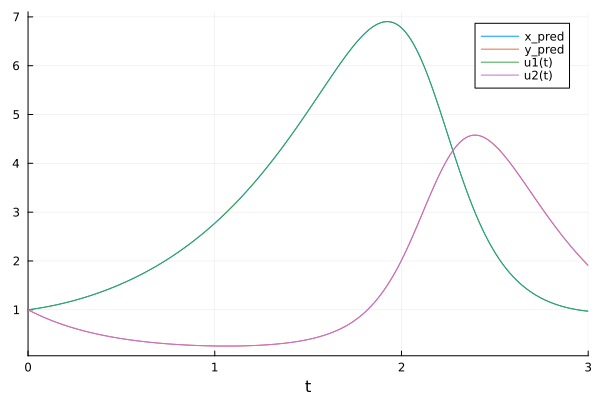

In [17]:
using Plots

phi = pinn.phi
ts = [true_sol.t...;;]
x_pred = phi.x(ts, res.u.x)
y_pred = phi.y(ts, res.u.y)

plot(vec(ts), vec(x_pred), label="x_pred")
plot!(vec(ts), vec(y_pred), label="y_pred")
plot!(true_sol)